# Assignment 8 - [30 points]

## <u>Case Study 1</u>: Seattle Airbnb Listing Analysis - Full Dataset - *Mixed Data Types*

Suppose that you work as a data scientist at Airbnb. You'd like to learn more about the main different types of Airbnb listings in the Seattle area and then use this information to advertise these different types of listings to interested customers. 

The following dataset is a sample of available Airbnb listings in Seattle, WA. These listings were collected in January 2016, and filtered to just contain listings from the five most popular Seattle neighborhoods (for Airbnb listings) and just contain listings that are either in a house or apartment property. Rows with missing values have already been dropped from the dataset.

This dataset contains the following variables.

**Listing Information**
The dataset contains the following information about the Airbnb *listing*:
* <u>price</u>: price of the listing (per night)(in US dollars)
* <u>review_scores_rating</u>: the average rating of the listing [0,100] (100 is the best)
* <u>number_of_reviews</u>: the number of reviews for the listing
* <u>security_deposit</u>: the security deposit required for the listing (in US dollars)
* <u>cleaning_fee</u>: the cleaning fee required for the listing (in US dollars)
* <u>neighborhood</u>: the neighborhood of Seattle the listing is located in
* <u>property_type</u>: is the listing in a 'House' or 'Apartment'
* <u>room_type</u>: is the listing a 'Entire home/apt', 'Private room', or 'Shared room'
* <u>accommodates</u>: how many guests will the listing accommodate
* <u>bathrooms</u>:how many bathrooms does the listing have
* <u>beds</u>: how many beds does the listing have

**Host Information**
The dataset also contains the following information about the *host* of the given Airbnb listing:
* <u>host_is_superhost</u>: is the host a "superhost": t=True, f=False
* <u>host_has_profile_pic</u>: does the host have a profile pic in their bio: t=True, f=False
* <u>host_response_time</u>: how fast will the host respond to requests (on average)
* <u>host_acceptance_rate</u>: what percent of booking requests will the host accept

### <u>Research Goals</u>:

In this analysis, we have the following research goals.

1. Identify larger "main clusters" of Airbnb listings in the Seattle area. In general, we would like for most of our listings to be clustered in with a larger cluster, rather than be separated as small or singleton clusters.
2. We would also like to identify potential sub-clusters of listings within each of the "main clusters."
3. What are the most dissimilar clusters of Airbnb listings in this dataset? What makes them so dissimilar?
4. What attributes characterize each of these clusters and sub-clusters?

#### Imports

In [290]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing

In [291]:
from kmodes.kprototypes import KPrototypes

from gower import gower_matrix

## 1. Data Preprocessing and Cleaning

### 1.1. Original Dataset
Read the seattle_airbnb_listings_cleaned.csv into a dataframe. This dataframe has already been cleaned (rows with missing values have already been dropped).

In [292]:
df = pd.read_csv('seattle_airbnb_listings_cleaned.csv')
df_raw = df.copy()

In [293]:
df.head()

price  review_scores_rating  number_of_reviews  security_deposit  \
0    300                   100                 24               500   
1    149                    96                 11               300   
2     95                    95                 79               150   
3    105                   100                 13               500   
4    140                    99                 30               250   

   cleaning_fee neighborhood property_type        room_type  accommodates  \
0            95  Wallingford         House  Entire home/apt             5   
1           105  Wallingford     Apartment  Entire home/apt             6   
2            40  Wallingford     Apartment  Entire home/apt             3   
3            50  Wallingford         House     Private room             2   
4            65  Wallingford         House  Entire home/apt             2   

   bathrooms  beds  host_response_time  host_response_rate  \
0        1.5     3  within a few hours                 1.0   
1        1.0     3      within an hour                 1.0   
2        1.0     2      within an hour                 1.0   
3        2.0     1  within a few hours                 1.0   
4        1.0     1      within an hour                 1.0   

   host_acceptance_rate host_is_superhost host_has_profile_pic  \
0                     1                 t                    t   
1                     1                 f                    t   
2                     1                 f                    t   
3                     1                 t                    t   
4                     1                 t                    t   

  host_identity_verified  predicted_cluster  
0                      t                  0  
1                      t                  1  
2                      t                  1  
3                      t                  2  
4                      t                  0

### 1.2. Numerical Variable Scaling

Next, we would like to cluster this dataset with the k-prototypes clustering algorithm and would like to determine if we should scale our numerical variables before running this algorithm.


#### 1.2.1. Describe the numerical variables

First, calculate the mean, standard deviation, minimum, maximum, median, Q1, and Q3 for each of the numerical variables in the dataset.

In [294]:
df.describe()

price  review_scores_rating  number_of_reviews  security_deposit  \
count  339.000000            339.000000         339.000000        339.000000   
mean   133.268437             94.415929          27.831858        276.351032   
std     92.597727              7.205840          35.862881        266.278501   
min     35.000000             20.000000           1.000000         95.000000   
25%     80.500000             93.000000           5.000000        150.000000   
50%    115.000000             96.000000          14.000000        250.000000   
75%    150.000000             99.000000          37.000000        300.000000   
max    999.000000            100.000000         278.000000       2500.000000   

       cleaning_fee  accommodates   bathrooms        beds  host_response_rate  \
count    339.000000    339.000000  339.000000  339.000000          339.000000   
mean      60.259587      3.469027    1.205015    1.790560            0.956696   
std       41.507793      2.122314    0.554704    1.213984            0.095461   
min        5.000000      1.000000    0.500000    1.000000            0.250000   
25%       35.000000      2.000000    1.000000    1.000000            0.970000   
50%       50.000000      3.000000    1.000000    1.000000            1.000000   
75%       79.000000      4.000000    1.000000    2.000000            1.000000   
max      300.000000     16.000000    3.500000   10.000000            1.000000   

       host_acceptance_rate  predicted_cluster  
count            339.000000         339.000000  
mean               0.997050           0.961652  
std                0.054313           0.662837  
min                0.000000           0.000000  
25%                1.000000           1.000000  
50%                1.000000           1.000000  
75%                1.000000           1.000000  
max                1.000000           2.000000

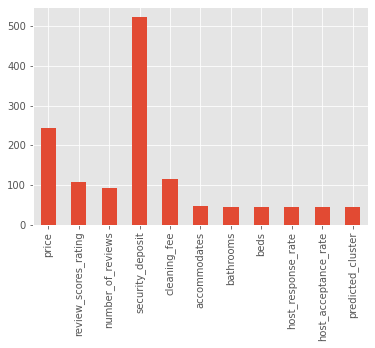

In [295]:
df.describe().mean().plot.bar()
plt.show()

#### 1.2.2. Should we scale?

Do we think that there are some numerical variables that will have a stronger influence on the the k-prototypes algorithm results than others? If so, give a numerical variable that we think will have a strong influence and one that we think will have a weak influence. Why do we think that these variables will have a stronger and weaker effect on k-prototypes, respectively?

> Since k-prototype algorithm minimizes Euclidean distance squared for the numerical variables along with hamming distance for categorical variables, the scale of numerical variables will affect the cost function values.

> We can see above that scale of security_deposit is very high compared to rest of the others. This variable will have a stronger effect on k-prototypes.

#### 1.2.3. Scale the numerical variables

Next, create a new dataframe that is comprised of the numerical and categorical variables, where the numerical variables have been scaled. You should scale each of the numerical variables by subtracting their respective means and then dividing by their respective standard deviations.

You should also make a copy of this dataframe that will be used just for clustering and checking clusterability.

In [296]:
df_numerical = df.loc[:, df.columns.isin(df.describe().columns)]
df_numerical.drop(columns=['predicted_cluster'], inplace=True)

In [297]:
df_numerical_scaled = (df_numerical - df_numerical.mean())/df_numerical.std()

In [298]:
df_numerical_scaled.head()

price  review_scores_rating  number_of_reviews  security_deposit  \
0  1.800601              0.774937          -0.106847          0.839906   
1  0.169891              0.219832          -0.469339          0.088813   
2 -0.413276              0.081055           1.426772         -0.474507   
3 -0.305282              0.774937          -0.413571          0.839906   
4  0.072697              0.636161           0.060456         -0.098960   

   cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0      0.836961      0.721370   0.531788  0.996257            0.453631   
1      1.077880      1.192554  -0.369593  0.996257            0.453631   
2     -0.488091     -0.220998  -0.369593  0.172522            0.453631   
3     -0.247173     -0.692182   1.433170 -0.651212            0.453631   
4      0.114205     -0.692182  -0.369593 -0.651212            0.453631   

   host_acceptance_rate  
0              0.054313  
1              0.054313  
2              0.054313  
3              0.054313  
4              0.054313

In [299]:
df_categorical = df.loc[:, ~df.columns.isin(df.describe().columns)]
df_categorical.head(1)

neighborhood property_type        room_type  host_response_time  \
0  Wallingford         House  Entire home/apt  within a few hours   

  host_is_superhost host_has_profile_pic host_identity_verified  
0                 t                    t                      t

In [300]:
X = df_numerical_scaled.join(df_categorical)
X.head(3)

price  review_scores_rating  number_of_reviews  security_deposit  \
0  1.800601              0.774937          -0.106847          0.839906   
1  0.169891              0.219832          -0.469339          0.088813   
2 -0.413276              0.081055           1.426772         -0.474507   

   cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0      0.836961      0.721370   0.531788  0.996257            0.453631   
1      1.077880      1.192554  -0.369593  0.996257            0.453631   
2     -0.488091     -0.220998  -0.369593  0.172522            0.453631   

   host_acceptance_rate neighborhood property_type        room_type  \
0              0.054313  Wallingford         House  Entire home/apt   
1              0.054313  Wallingford     Apartment  Entire home/apt   
2              0.054313  Wallingford     Apartment  Entire home/apt   

   host_response_time host_is_superhost host_has_profile_pic  \
0  within a few hours                 t                    t   
1      within an hour                 f                    t   
2      within an hour                 f                    t   

  host_identity_verified  
0                      t  
1                      t  
2                      t

### 1.3. Gower's distance matrix

Next, use this resulting copied dataframe from 1.2.3 to create a Gower's distance matrix for the Airbnb listings.

In [301]:
dist_mat=gower_matrix(X)
dist_mat

array([[0.        , 0.21199778, 0.24804668, ..., 0.28073728, 0.14300306,
        0.21565527],
       [0.21199778, 0.        , 0.05340142, ..., 0.07566873, 0.20837322,
        0.13374592],
       [0.24804668, 0.05340142, 0.        , ..., 0.09874564, 0.25014165,
        0.16251989],
       ...,
       [0.28073728, 0.07566873, 0.09874564, ..., 0.        , 0.16240685,
        0.08007025],
       [0.14300306, 0.20837322, 0.25014165, ..., 0.16240685, 0.        ,
        0.10222678],
       [0.21565527, 0.13374592, 0.16251989, ..., 0.08007025, 0.10222678,
        0.        ]], dtype=float32)

## 2. Clusterability

### 2.1. t-SNE Plots
Using 6 different perplexity values and at least two random states for each perplexity value, map this **distance matrix** onto a two-dimensional dataset with the t-SNE algorithm. Show your projected coordinates in a scatterplot for each combination of random states and perplexity value.

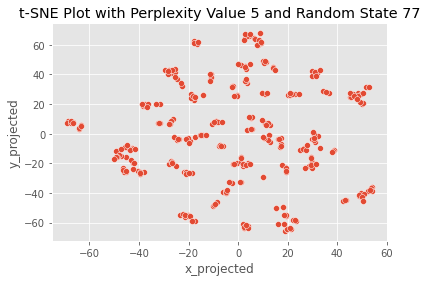

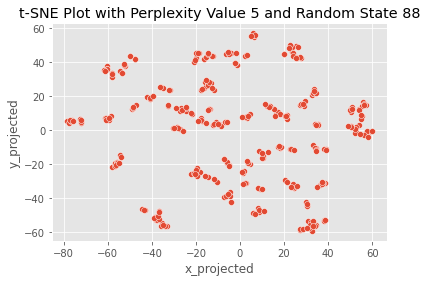

--------------------------------------------


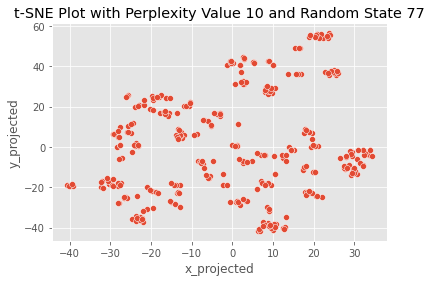

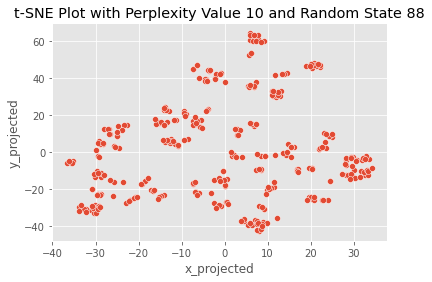

--------------------------------------------


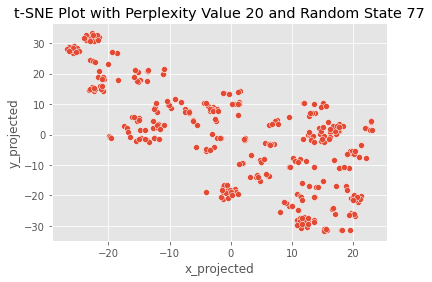

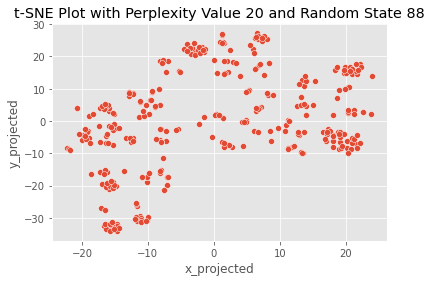

--------------------------------------------


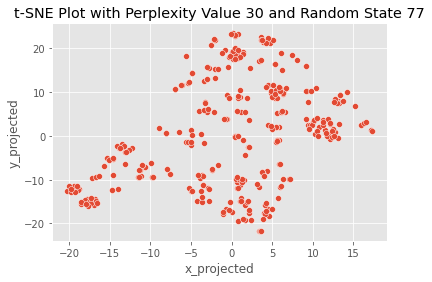

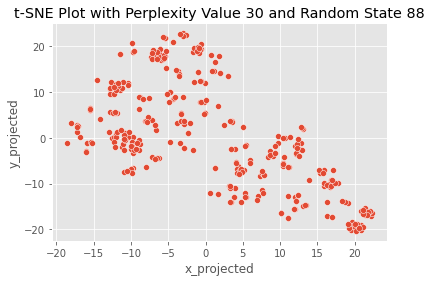

--------------------------------------------


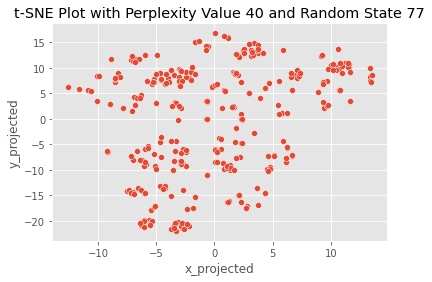

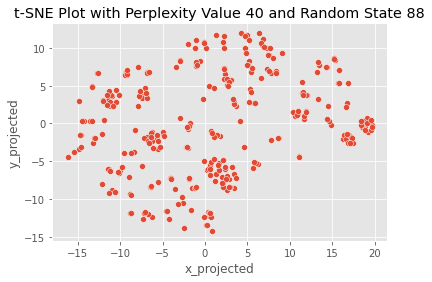

--------------------------------------------


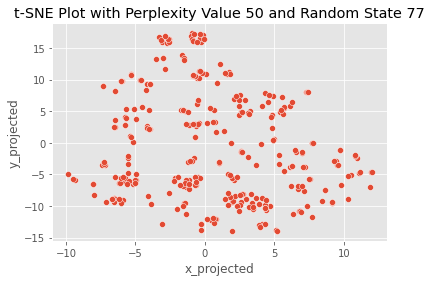

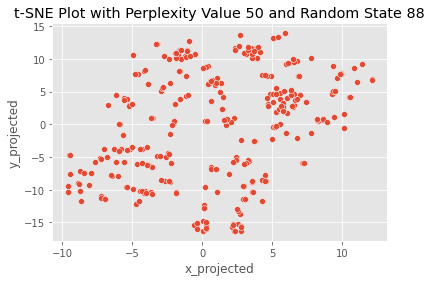

--------------------------------------------


In [44]:
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [77, 88]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

### 2.2 Assessing Clustering Structure

Answer the following questions below.

1. Does the t-SNE algorithm suggest that this dataset is clusterable?
2. How many "main clusters" do you think that this dataset has? *[Subjective Answer: As long as your logic is correct, you will not lose points].*
3. Do you think that this dataset has nested clusters (ie. subclusters)? Explain. *[Subjective Answer: As long as your logic is correct, you will not lose points].*

Finally, pick out a random state and perplexity value that reflects the answers to your questions and show the corresponding t-SNE plot below.

> 1. There seems to be a lot of noise, but it also seems that there are clusters in the data. e.g. if we look at the random state 88 and perplexity value of 30, it seems that there could be two main clusters along with many sub-clusters.

> 2. Looking at perplexity of 30 and random state 88, there seems to be two main clusters.

> 3. Again, looking at perplexity 30 and random state 88, we can see there are small dense areas where many objects are present. These dense clusters are also well seperated.

### 2.3. Association between the Attributes and the Clustering Structure Suggested by the t-SNE Plots

Finally, we would like to assess how each of our 17 attributes is individually associated with the clustering structure suggested by our selected t-SNE plot from 2.2. Below, plot your t-SNE plot 17 times, each time color coding the points by each of the 17 attributes.

In [ ]:
num_row = 6
num_col = 3

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    
    sns.scatterplot(x='x_projected',y='y_projected', data=df_combo,
                    c=df_categorical.iloc[:,i], ax=ax)
    
    ax.set_title(f'{df_categorical.columns[i]}')

plt.tight_layout()
plt.show()

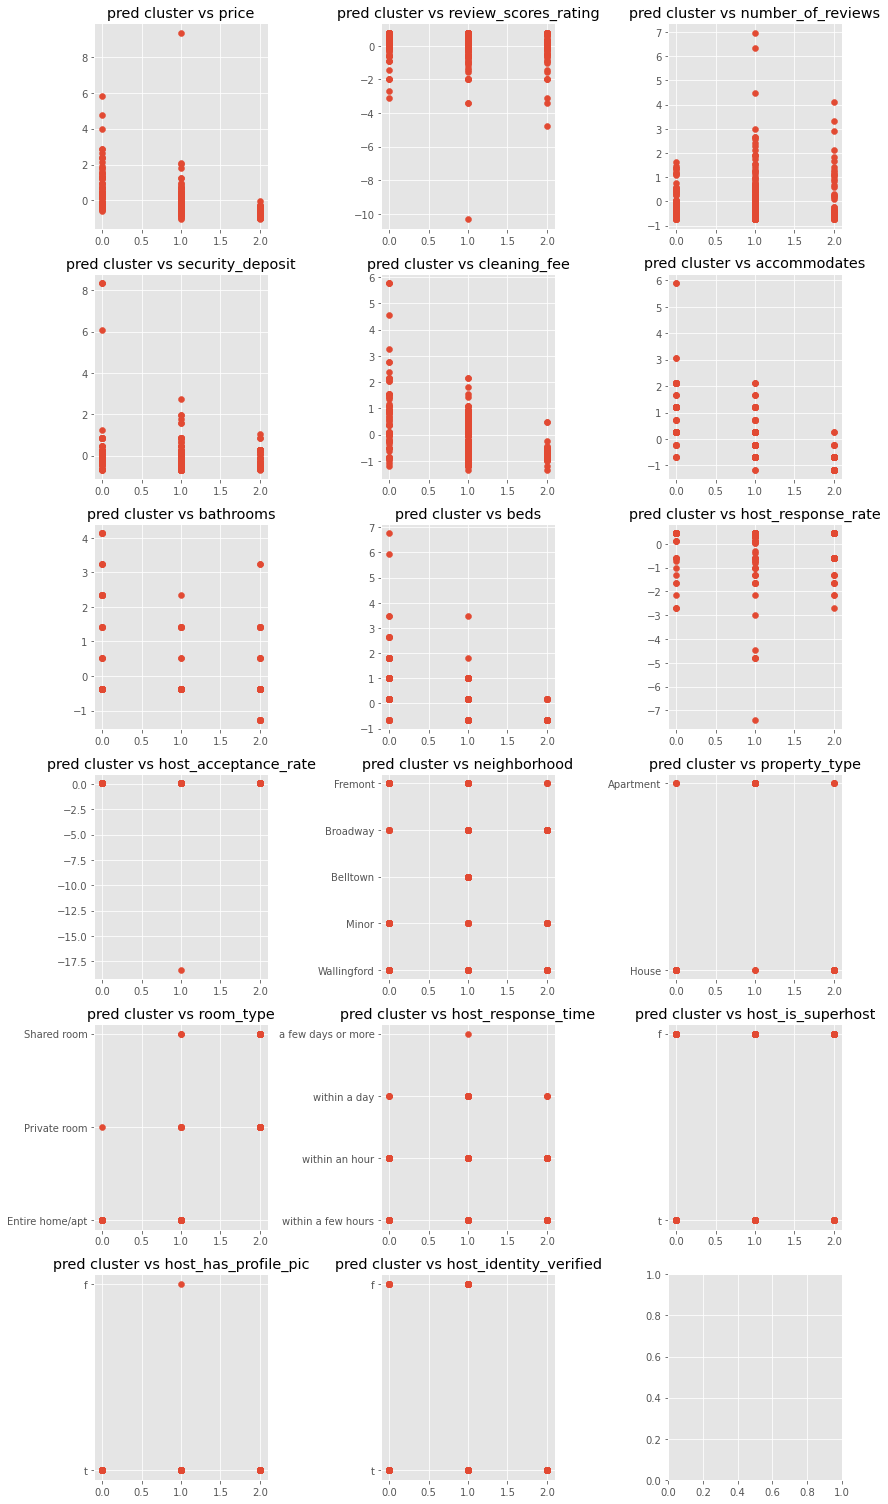

In [60]:
num_row = 6
num_col = 3

# get a segment of the dataset
num = num_row*num_col
labels = X.columns

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    
    ax.scatter(x=df['predicted_cluster'], y=X.loc[:, X.columns[i]])

    ax.set_title(f'pred cluster vs {X.columns[i]}')

plt.tight_layout()
plt.show()

## 3. K-Prototypes - *Parameter Selection*

First, we would like to cluster this dataset with the k-prototypes algorithm. We would like to explore what the best values of $k$ and $\gamma$ would be to use in this clustering algorithm to meet our research goals.



### 3.1. $\gamma = 0.25$

#### 3.1.1. Elbow Plot
Create an elbow plot for the k-prototypes algorithm using a value of $\gamma=0.25$. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-prototypes algorith, using a random state of 100.

In [68]:
np.arange(10, len(X.columns), 1)

array([10, 11, 12, 13, 14, 15, 16])

In [83]:
cost = []
for num_clusters in list(range(1,16)):
    kp = KPrototypes(n_clusters=num_clusters, random_state=100, gamma=0.25)
    kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])
    cost.append(kp.cost_)

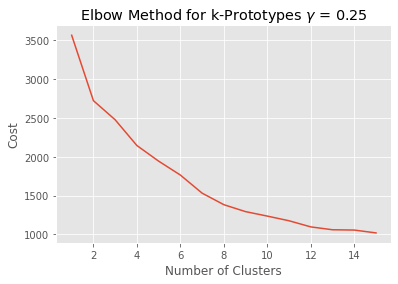

In [84]:
plt.plot(list(range(1,16)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes $\gamma$ = 0.25')
plt.show()

#### 3.1.2. t-SNE Plots

For k=1, k=2,..., k=10, run the k-prototypes clustering algorithm on your dataset, using a value of $\gamma=0.25$ and a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

In [75]:
kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])

array([ 0, 11,  3,  6,  6,  6,  0, 11,  6,  3,  6, 11, 11, 12, 12,  3,  3,
       11, 11,  6,  8,  8,  8,  1, 11,  8, 11,  8,  5,  8, 11, 11, 11, 11,
       11, 12,  1,  3, 11,  8,  6,  3, 11,  8, 11,  8, 11, 12,  8,  0,  6,
        0,  8,  3,  8,  6,  6,  0,  8,  0,  6, 11,  6,  8,  3, 11,  0,  5,
        3,  3,  3,  0,  5,  8,  6,  3,  3,  3,  8,  6, 11,  6,  8,  6,  3,
        8,  3,  8, 11, 11, 11,  9,  6,  6, 11,  8,  6,  8, 11,  5,  5,  3,
        8,  8,  6,  6,  0, 11,  9,  6, 11,  5,  6, 11, 11,  6,  7,  6,  6,
       10,  6, 11,  6,  6,  6,  6,  3, 12,  6,  6,  6, 11,  2,  0, 11,  6,
        0, 12,  6,  8, 11,  6, 11,  6,  6, 11,  6,  6, 11,  6,  6, 11,  6,
        6,  3,  6,  6,  3,  6, 11, 12,  8,  6, 12,  3,  6,  6,  6,  0,  6,
        6,  8,  6,  2,  3,  3,  3,  6,  6, 14,  6,  0,  0,  6,  1, 14, 12,
       12,  6,  6, 14,  3,  6,  6,  0, 12, 11,  6,  2,  3,  1,  3,  6, 12,
        6,  6, 11,  6,  8,  0,  8,  8,  1,  1,  6, 11, 11,  2, 11,  1,  3,
        6,  8,  6,  9,  6

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=88, metric='precomputed')
data_tsne = tsne.fit_transform(dist_mat)
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df, df_tsne], axis=1)

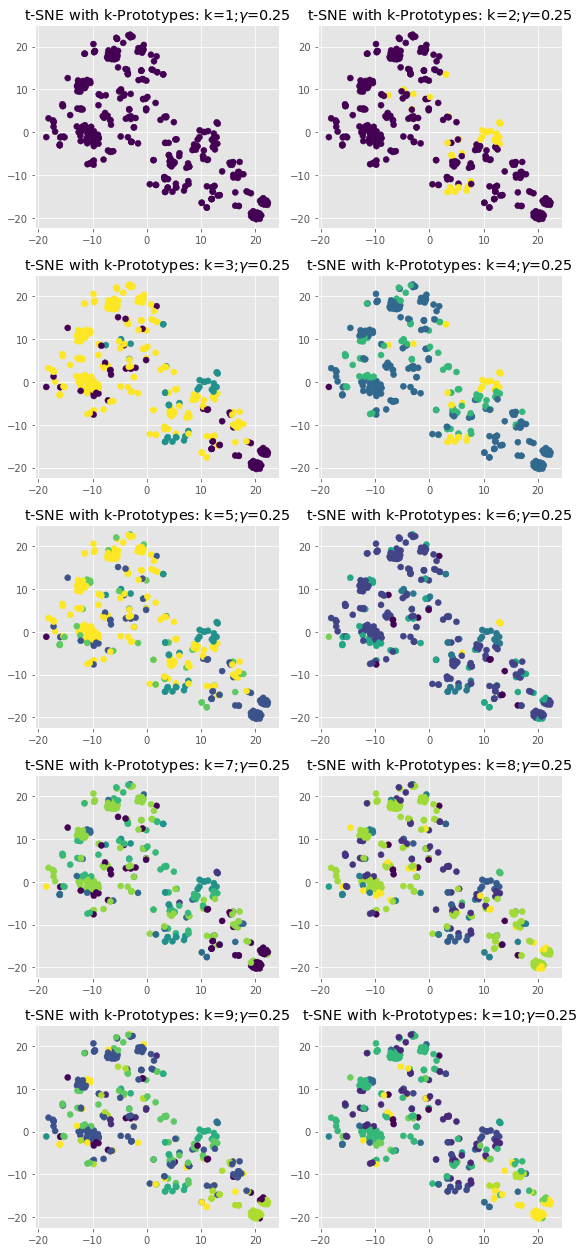

In [85]:
num_row = 5
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col):
    ax = axes[i//num_col, i%num_col]
    
    kp = KPrototypes(n_clusters=i+1, random_state=100, gamma=0.25)
    pred = kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])
    
    ax.scatter(x=df_combo['x_projected'], y=df_combo['y_projected'], c=pred)

    ax.set_title(f't-SNE with k-Prototypes: k={i+1};$\gamma$=0.25')

plt.tight_layout()
plt.show()

### 3.2. $\gamma = 0.5$ 

#### 3.2.1. Elbow Plot
Create an elbow plot for the k-prototypes algorithm using a value of $\gamma=0.5$. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-prototypes algorith, using a random state of 100.

In [80]:
cost = []
for num_clusters in list(range(1,16)):
    kp = KPrototypes(n_clusters=num_clusters, random_state=100, gamma=0.5)
    kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])
    cost.append(kp.cost_)

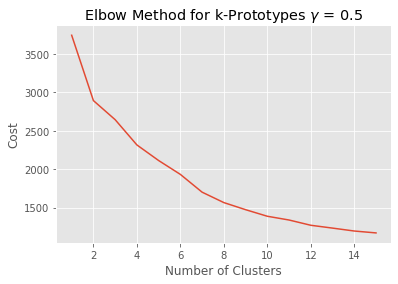

In [81]:
plt.plot(list(range(1,16)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes $\gamma$ = 0.5')
plt.show()

#### 3.1.2. t-SNE Plots

For k=1, k=2,..., k=10, run the k-prototypes clustering algorithm on your dataset, using a value of $\gamma=0.5$ and a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

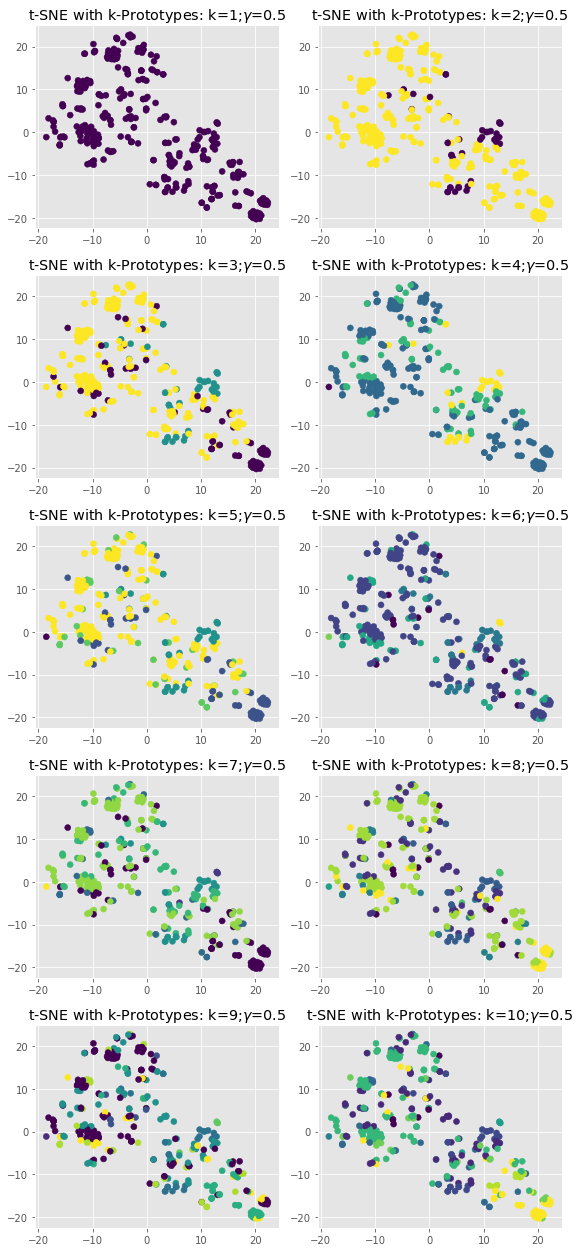

In [86]:
num_row = 5
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col):
    ax = axes[i//num_col, i%num_col]
    
    kp = KPrototypes(n_clusters=i+1, random_state=100, gamma=0.5)
    pred = kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])
    
    ax.scatter(x=df_combo['x_projected'], y=df_combo['y_projected'], c=pred)

    ax.set_title(f't-SNE with k-Prototypes: k={i+1};$\gamma$=0.5')

plt.tight_layout()
plt.show()

### 3.3. $\gamma = 100$ 

#### 3.3.1. Elbow Plot
Create an elbow plot for the k-prototypes algorithm using a value of $\gamma=100$. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-prototypes algorith, using a random state of 100.

In [87]:
cost = []
for num_clusters in list(range(1,16)):
    kp = KPrototypes(n_clusters=num_clusters, random_state=100, gamma=100)
    kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])
    cost.append(kp.cost_)

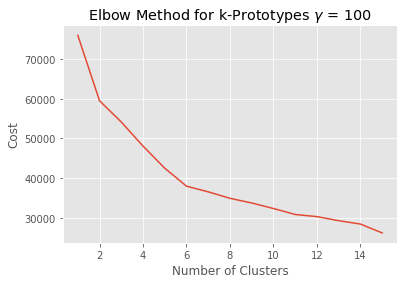

In [88]:
plt.plot(list(range(1,16)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes $\gamma$ = 100')
plt.show()

#### 3.1.3. t-SNE Plots

For k=1, k=2,..., k=10, run the k-prototypes clustering algorithm on your dataset, using a value of $\gamma=100$ and a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

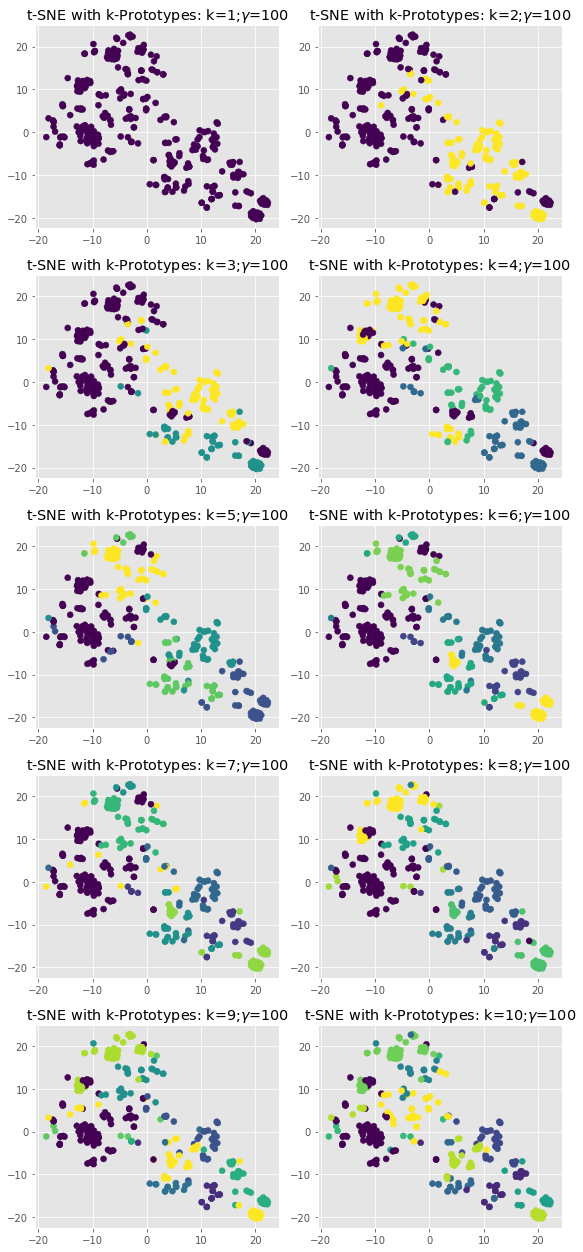

In [89]:
num_row = 5
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col):
    ax = axes[i//num_col, i%num_col]
    
    kp = KPrototypes(n_clusters=i+1, random_state=100, gamma=100)
    pred = kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])
    
    ax.scatter(x=df_combo['x_projected'], y=df_combo['y_projected'], c=pred)

    ax.set_title(f't-SNE with k-Prototypes: k={i+1};$\gamma$=100')

plt.tight_layout()
plt.show()

### 3.4. Interpretation

#### 3.4.1. Elbow Plots

Do we think that any of the values of gamma used above (ie. $\gamma \in \{0.25, 0.5, 100\}$) in the k-prototypes algorithm will be able to identify a *strong* clustering relationship in the dataset? Explain.

> Yes, we can see that $\gamma$ value of 100 seems to perform well in identifying the clusters.

#### 3.4.2. $\gamma$ Interpretation

Which value of $\gamma \in \{0.25, 0.5, 100\}$  will the numerical variables have the strongest influence on the results of the k-prototypes algorithm? Which value of $\gamma \in \{0.25, 0.5, 100\}$  will the categorical variables have the strongest influence on the results of the k-prototypes algorithm?

> Looking at the t-SNE plot with k-prototype algorithm and value of $\gamma$ = 100 gives us better results and we can see clusters being identified correctly.

> The Gower's distance metric gives high weightage to categorical variables as value of $\gamma$ increases. Hence, $\gamma$ = 100 will result in strong influence of categorical variables on the results of the k-prototypes algorithm.

#### 3.4.3. Result that is most consistent with t-SNE plots

Which value of $\gamma \in \{0.25, 0.5, 100\}$ produced k-prototypes clustering results that were most consistent with the clustering structure suggested by the t-SNE plots?

> $\gamma$ value of 100 among $\gamma \in \{0.25, 0.5, 100\}$ produced best clustering results that were most consistent with the clustering structer suggested by the t-SNE plot.

#### 3.4.4. t-SNE Plot with Gower's Distance

Using what we know so far, do we think that the clustering structure that is suggested by this particular t-SNE plot happens to be more dominated by the categorical variables, the numerical variables, or are the numerical and categorical variables equally represented? Explain.

> The t-SNE plot seem to be dominated by numerical variables. We needed to increase value of $\gamma$ to increase representation of categorical variables.

<hr>

**Tutorial**:
You can use the **.inverse_transform()** function to unscale a set of numerical values using the same column means and and standard deviations that were used to scale another dataset.

In [90]:
import pandas as pd
tmp1=pd.DataFrame({'x': [1,2,3], 'y': [-1,10,3]})
tmp1

x   y
0  1  -1
1  2  10
2  3   3

In [91]:
from sklearn.preprocessing import StandardScaler
st_tmp=StandardScaler()

st_tmp.fit_transform(tmp1)

array([[-1.22474487, -1.09985336],
       [ 0.        ,  1.31982404],
       [ 1.22474487, -0.21997067]])

In [92]:
tmp2=pd.DataFrame({'x': [0.0,1.0], 'y': [2.-0,-1.0]})
tmp2

x    y
0  0.0  2.0
1  1.0 -1.0

In [93]:
st_tmp.inverse_transform(tmp2)

array([[ 2.        , 13.09212113],
       [ 2.81649658, -0.54606057]])

<hr>

### 3.5. Post Cluster Analysis with k-Prototypes and k=4 Clusters and $\gamma =100$.

#### 3.5.1. Cluster the Dataset

Finally, cluster the dataset one more time with k-Prototypes using k=4 Clusters and $\gamma =100$.

In [94]:
kp = KPrototypes(n_clusters=4, random_state=100, gamma=100)
# pred = kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])

#### 3.5.2. Prototypes

Next, display the four cluster prototypes. The numerical values in your prototypes that you display should be **unscaled**. Put your four prototypes all into the same dataframe.

In [98]:
st_df_numerical =StandardScaler()
st_df_numerical.fit_transform(df_numerical)
df_inverse_transformed = st_df_numerical.inverse_transform(df_numerical_scaled)

In [101]:
df_inverse_transformed = pd.DataFrame(df_inverse_transformed)
df_inverse_transformed.columns = df_numerical.columns
df_inverse_transformed.head(2)

price  review_scores_rating  number_of_reviews  security_deposit  \
0  299.753902             99.991758          24.005656        499.669891   
1  148.976780             95.997662          11.024844        299.965094   

   cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0     94.948723      4.997740   1.499565  2.998215            0.999936   
1    104.933962      5.996264   1.000303  2.998215            0.999936   

   host_acceptance_rate  
0              0.999996  
1              0.999996

In [104]:
X1 = df_inverse_transformed.join(df_categorical)
pred = kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])

In [108]:
df_inverse_transformed.columns

Index(['price', 'review_scores_rating', 'number_of_reviews',
       'security_deposit', 'cleaning_fee', 'accommodates', 'bathrooms', 'beds',
       'host_response_rate', 'host_acceptance_rate'],
      dtype='object')

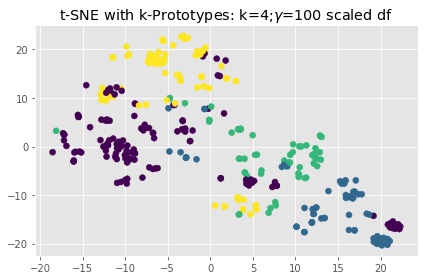

In [133]:
kp = KPrototypes(n_clusters=4, random_state=100, gamma=100)
pred = kp.fit_predict(X, categorical=[10, 11, 12, 13, 14, 15, 16])

plt.scatter(x=df_combo['x_projected'], y=df_combo['y_projected'], c=pred)

plt.title(f't-SNE with k-Prototypes: k=4;$\gamma$=100 scaled df')

plt.tight_layout()
plt.show()

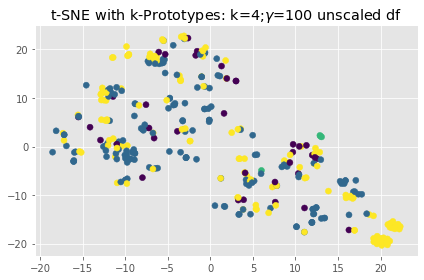

In [134]:
kp = KPrototypes(n_clusters=4, random_state=100, gamma=100)
pred_unscaled = kp.fit_predict(X1, categorical=[10, 11, 12, 13, 14, 15, 16])

plt.scatter(x=df_combo['x_projected'], y=df_combo['y_projected'], c=pred_unscaled)

plt.title(f't-SNE with k-Prototypes: k=4;$\gamma$=100 unscaled df')

plt.tight_layout()
plt.show()

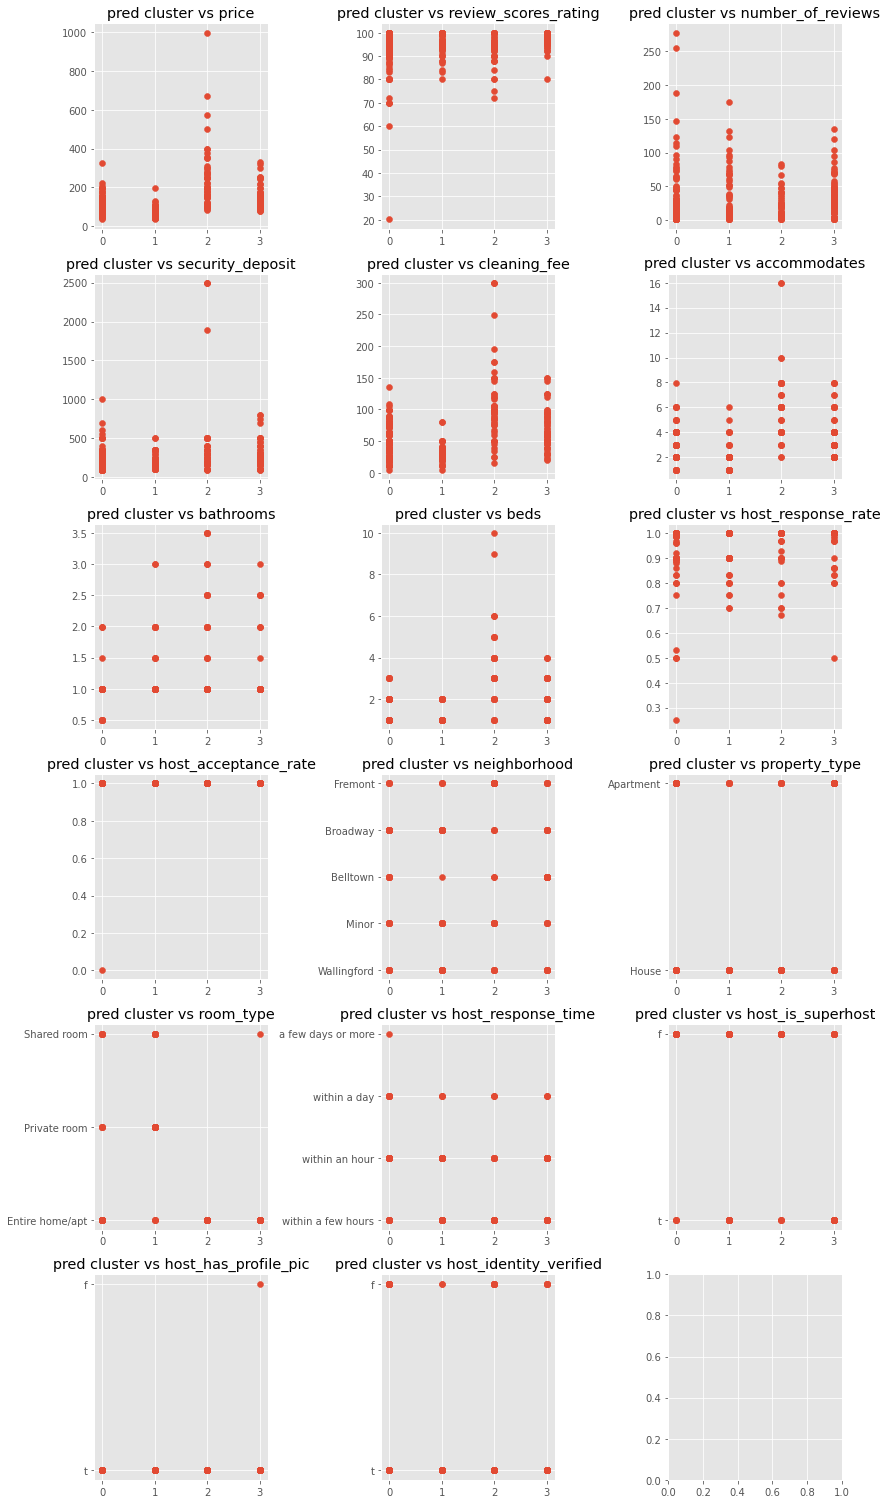

In [135]:
num_row = 6
num_col = 3

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    
    ax.scatter(x=pred, y=X1.loc[:, X1.columns[i]])
    
    ax.set_title(f'pred cluster vs {X.columns[i]}')

plt.tight_layout()
plt.show()

#### 3.5.3. Interpretation

What type of categorical attribute values are most common in the cluster with the highest average listing price?

*(Note: In a full analysis you would want to describe and compare every prototype to learn more about the cluster attributes)*.

In [136]:
df_categorical['kp_pred'] = pred

In [137]:
df_categorical.kp_pred.value_counts()

0    130
3     85
1     66
2     58
Name: kp_pred, dtype: int64

In [138]:
df_categorical.iloc[df_categorical[df_categorical['kp_pred']==2].index, :-1].describe()

neighborhood property_type        room_type  host_response_time  \
count            58            58               58                  58   
unique            5             2                1                   3   
top         Fremont         House  Entire home/apt  within a few hours   
freq             24            46               58                  43   

       host_is_superhost host_has_profile_pic host_identity_verified  
count                 58                   58                     58  
unique                 2                    1                      2  
top                    f                    t                      t  
freq                  52                   58                     45

> Cluster 2 has highest average listing price.

> We can see the 'top' values in each categorical variable for cluster having higest average listing price.

## 4. Hierarchical Agglomerative Clustering

Next, we would like to cluster our Gower's distance matrix with hierarchical agglomerative clustering using single linkage, complete linkage, and average linkage.



### 4.1. Single Linkage

#### 4.1.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with single linkage for using your Gower's distance matrix. 
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [347]:
df_categorical.drop(columns=['kp_pred'], inplace=True)
label_enc = {}
for col in df_categorical.columns:
    label_enc[col] = preprocessing.LabelEncoder()
    print(col)
    X[col] = label_enc[col].fit_transform(df_categorical[col])

In [151]:
X.head(2)

price  review_scores_rating  number_of_reviews  security_deposit  \
0  1.800601              0.774937          -0.106847          0.839906   
1  0.169891              0.219832          -0.469339          0.088813   

   cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0      0.836961      0.721370   0.531788  0.996257            0.453631   
1      1.077880      1.192554  -0.369593  0.996257            0.453631   

   host_acceptance_rate  neighborhood  property_type  room_type  \
0              0.054313             4              1          0   
1              0.054313             4              0          0   

   host_response_time  host_is_superhost  host_has_profile_pic  \
0                   2                  1                     1   
1                   3                  0                     1   

   host_identity_verified  
0                       1  
1                       1

In [155]:
dist_mat=gower_matrix(X)
dist_mat

array([[0.        , 0.1727821 , 0.20883098, ..., 0.21210983, 0.11359129,
        0.1470278 ],
       [0.1727821 , 0.        , 0.05340142, ..., 0.04625697, 0.13974576,
        0.10433416],
       [0.20883098, 0.05340142, 0.        , ..., 0.06933387, 0.1815142 ,
        0.13310812],
       ...,
       [0.21210983, 0.04625697, 0.06933387, ..., 0.        , 0.12319116,
        0.08007025],
       [0.11359129, 0.13974576, 0.1815142 , ..., 0.12319116, 0.        ,
        0.06301109],
       [0.1470278 , 0.10433416, 0.13310812, ..., 0.08007025, 0.06301109,
        0.        ]], dtype=float32)

In [305]:
Z = linkage(dist_mat, method='single')
Z

array([[143.        , 169.        ,   0.        ,   2.        ],
       [180.        , 188.        ,   0.        ,   2.        ],
       [268.        , 283.        ,   0.        ,   2.        ],
       ...,
       [262.        , 673.        ,   1.24580001, 337.        ],
       [280.        , 674.        ,   1.29983294, 338.        ],
       [170.        , 675.        ,   1.57853317, 339.        ]])

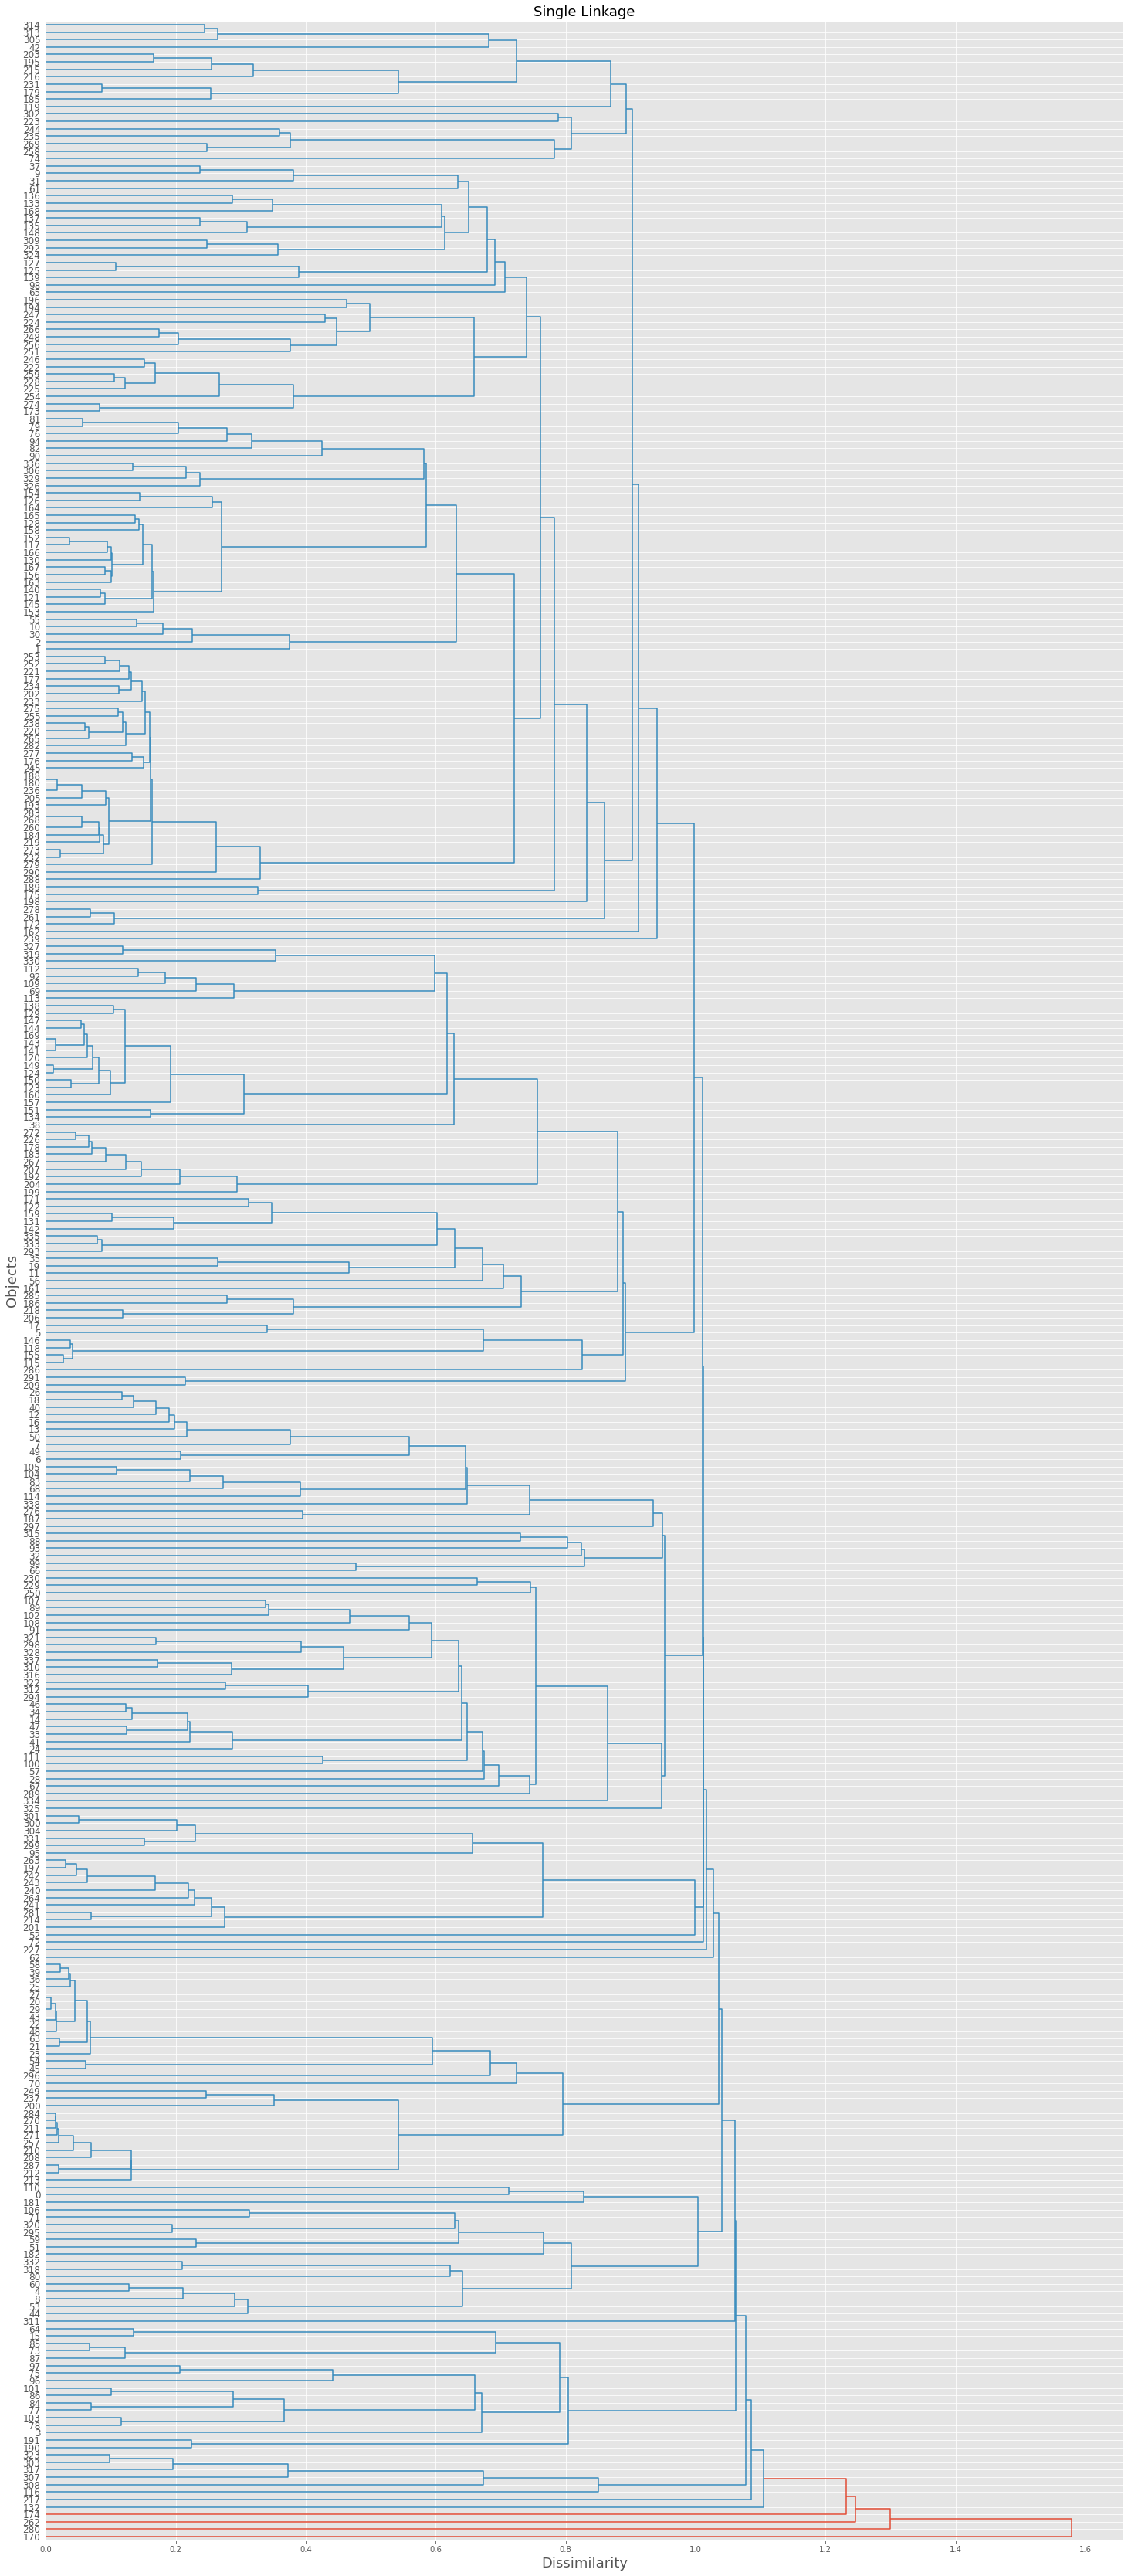

In [306]:
fig, ax = plt.subplots(figsize=(25, 60))
d = dendrogram(Z, orientation='right', ax=ax, labels=X.index,)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Single Linkage', fontsize=18)
plt.show()

#### 4.1.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

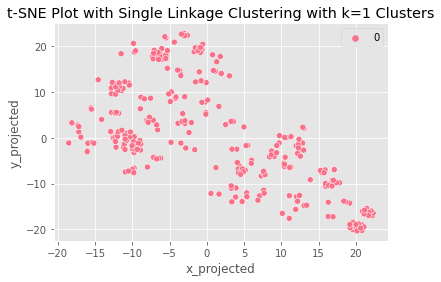

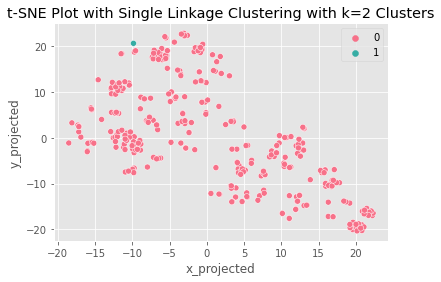

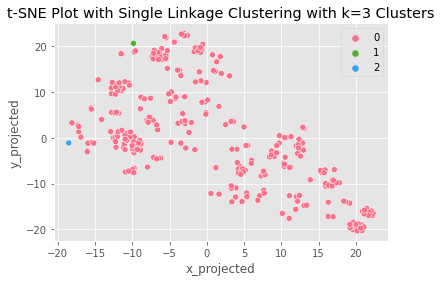

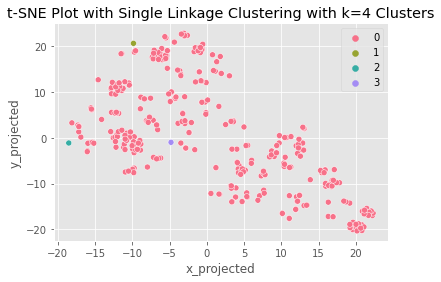

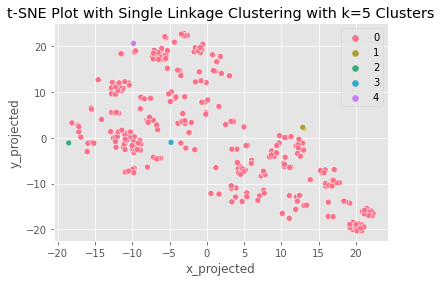

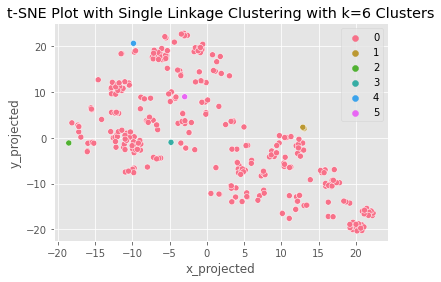

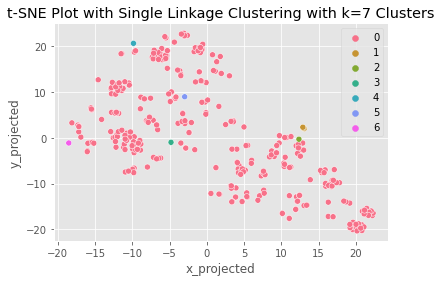

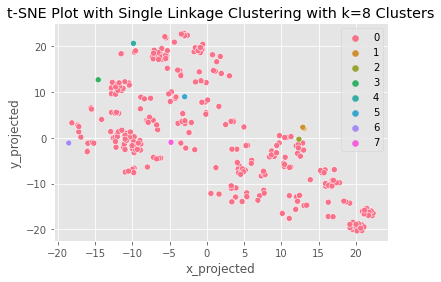

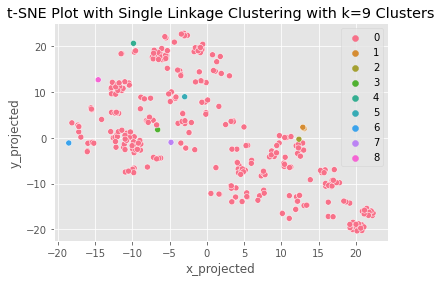

In [307]:
for k in range(1,10):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single')
    predicted_cluster = hac.fit_predict(dist_mat)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue=predicted_cluster, palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Single Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 4.2. Complete Linkage

#### 4.2.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with complete linkage using your Gower's distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [327]:
Z = linkage(dist_mat, method='complete')
Z

array([[ 20.        ,  27.        ,   0.        ,   2.        ],
       [ 22.        ,  43.        ,   0.        ,   2.        ],
       [143.        , 169.        ,   0.        ,   2.        ],
       ...,
       [649.        , 659.        ,   3.20173113,   6.        ],
       [672.        , 673.        ,   3.60603444, 333.        ],
       [674.        , 675.        ,   5.02290961, 339.        ]])

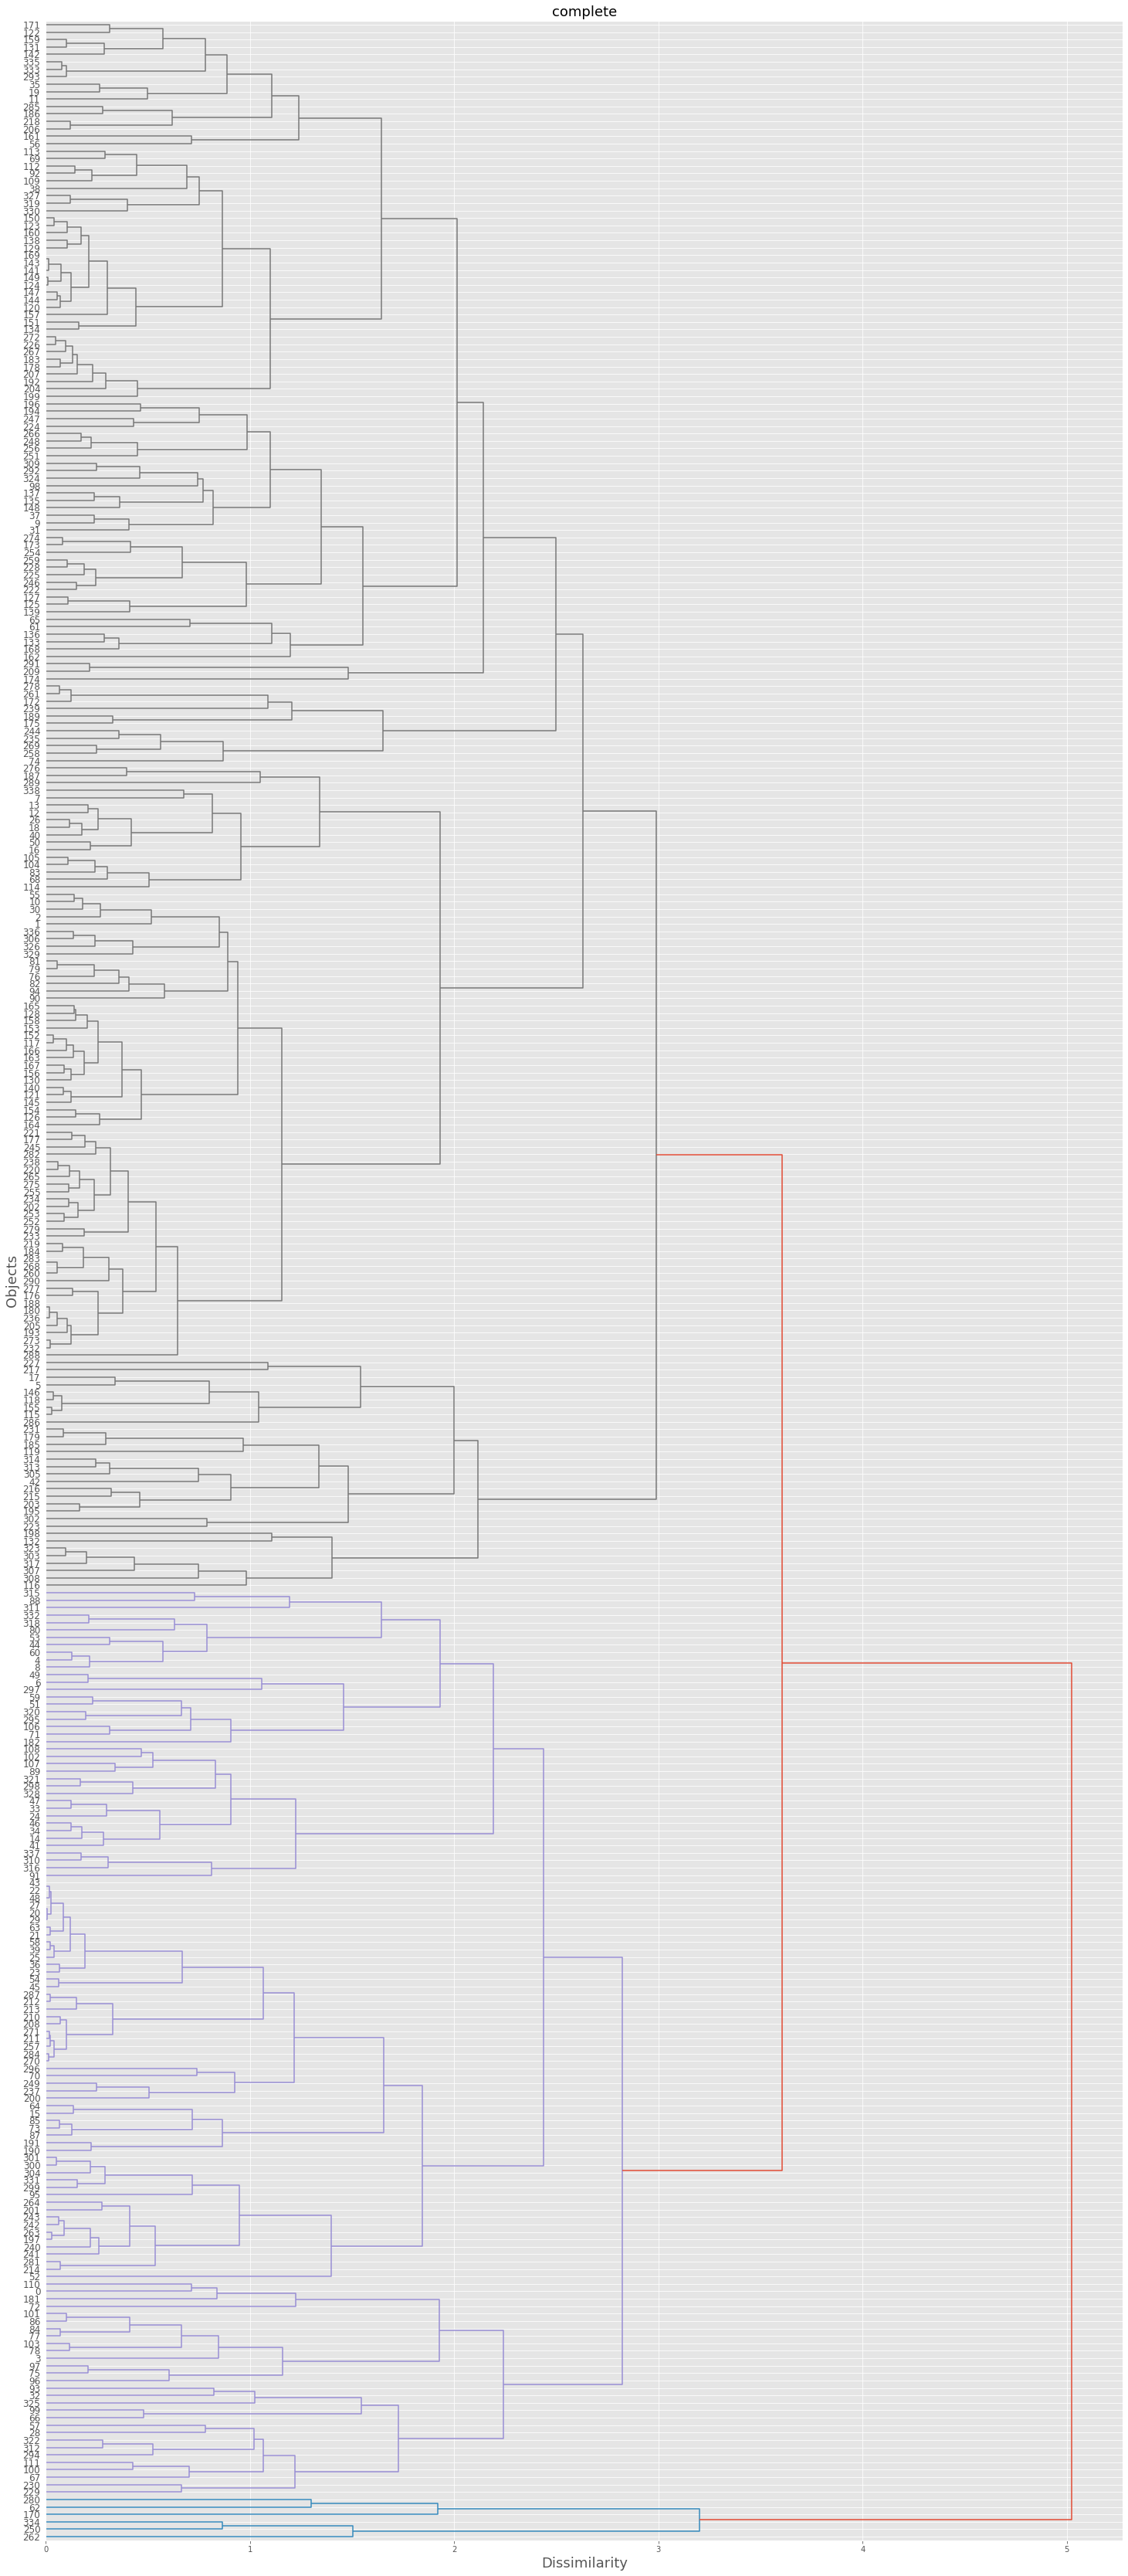

In [328]:
fig, ax = plt.subplots(figsize=(25, 60))
d = dendrogram(Z, orientation='right', ax=ax, labels=X.index,)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.title('complete', fontsize=18)
plt.show()

#### 4.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

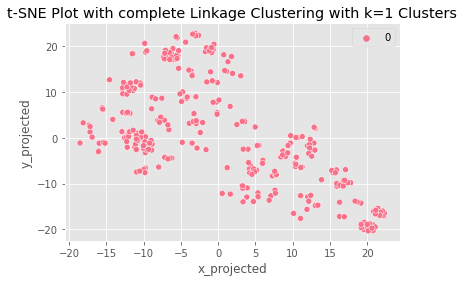

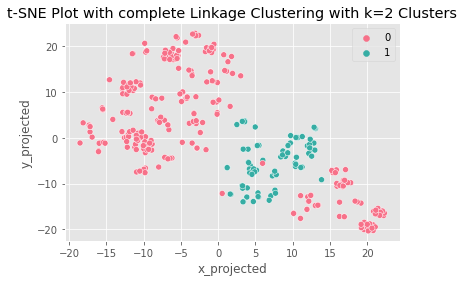

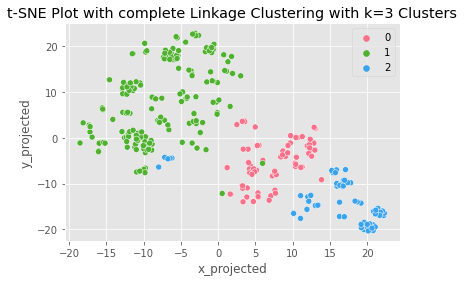

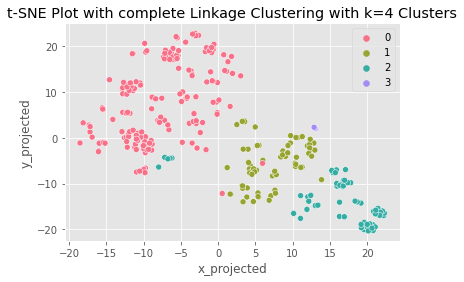

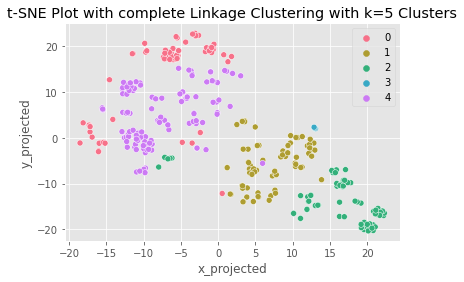

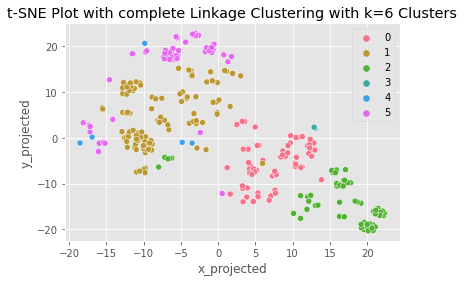

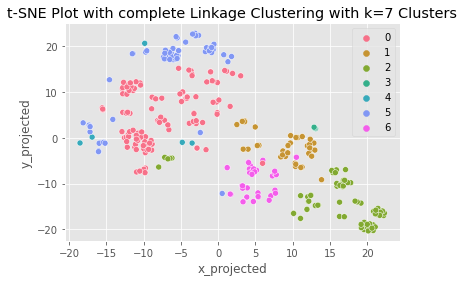

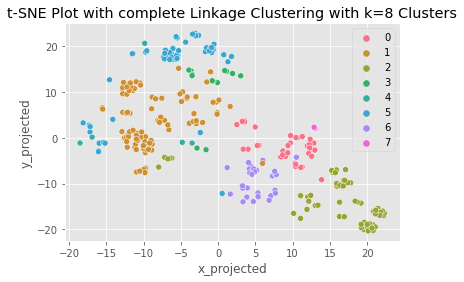

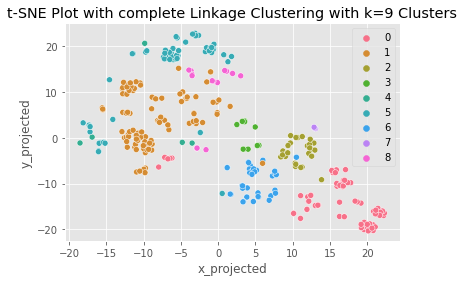

In [329]:
for k in range(1,10):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete')
    predicted_cluster = hac.fit_predict(dist_mat)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue=predicted_cluster, palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with complete Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 4.3. Average Linkage

#### 4.3.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with average linkage using your Gower's distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [179]:
Z = linkage(dist_mat, method='average')
Z

array([[ 20.        ,  27.        ,   0.        ,   2.        ],
       [ 22.        ,  43.        ,   0.        ,   2.        ],
       [180.        , 188.        ,   0.        ,   2.        ],
       ...,
       [672.        , 673.        ,   1.97137951, 336.        ],
       [262.        , 661.        ,   2.51740553,   3.        ],
       [674.        , 675.        ,   3.19994912, 339.        ]])

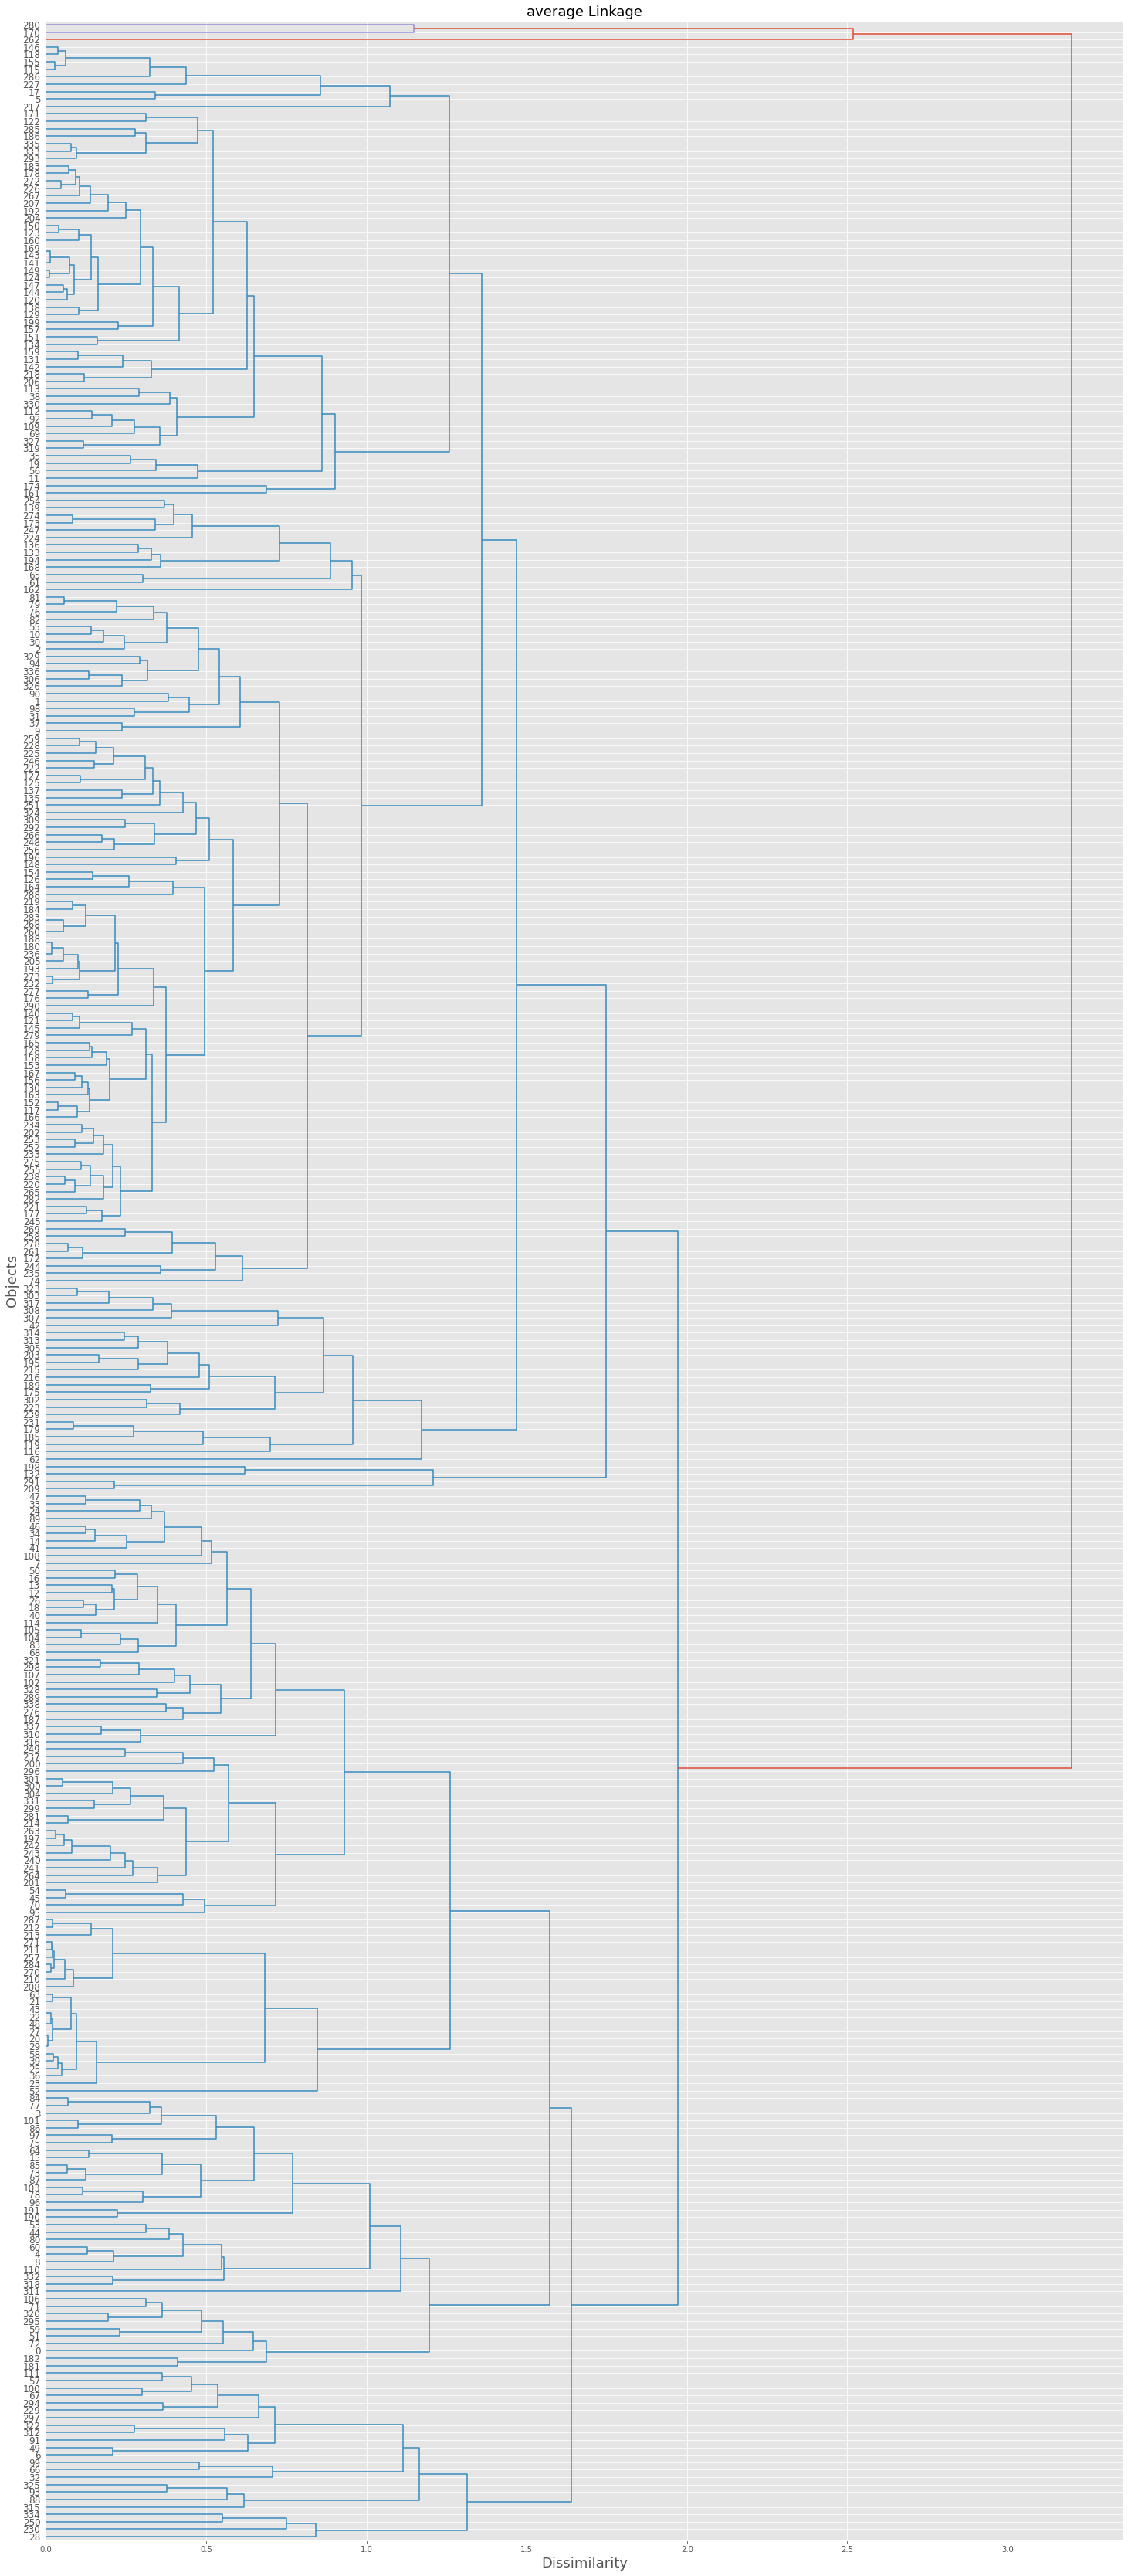

In [180]:
fig, ax = plt.subplots(figsize=(25, 60))
d = dendrogram(Z, orientation='right', ax=ax, labels=X.index,)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.title('average Linkage', fontsize=18)
plt.show()

#### 4.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

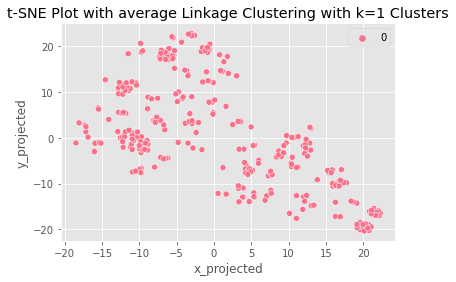

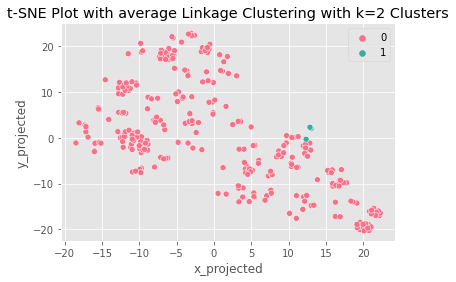

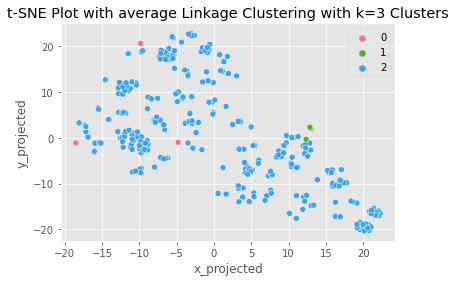

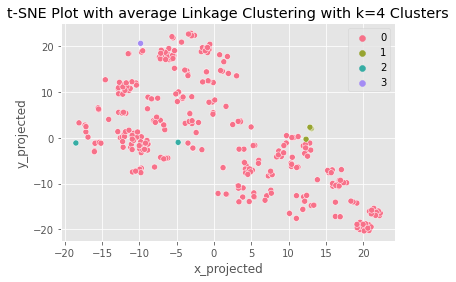

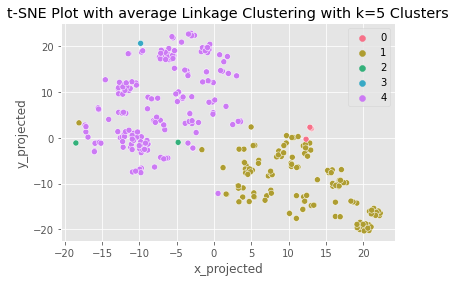

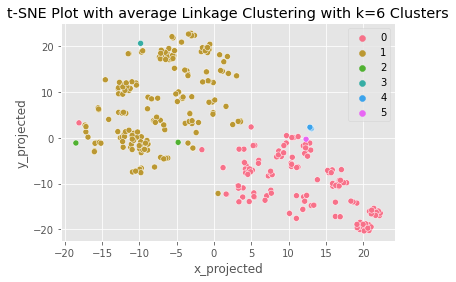

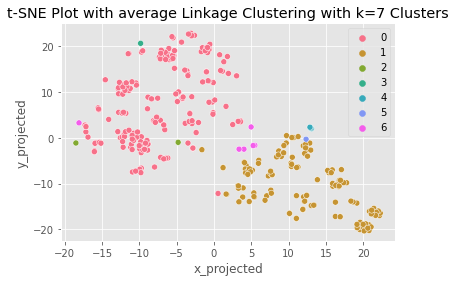

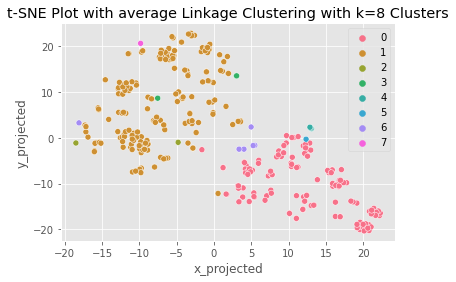

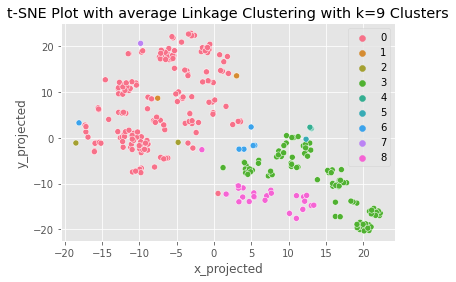

In [181]:
for k in range(1,10):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='average')
    predicted_cluster = hac.fit_predict(dist_mat)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue=predicted_cluster, palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with average Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 4.4. Interpretation

The goal of our cluster analysis in this example is to do the following.
1. Identify the "main clusters" that are actually present in this dataset.
2. Identify the nested nature of the clusters in this dataset.
3. To have most of our observations placed in a larger "main cluster" rather than being placed in a small/singleton clusters.

Given the goals of this cluster analysis, which of the following linkage functions do we think best met this goal: single linkage, complete linkage, or average linkage? Explain.

> Complete linkage best met our goal.

> Single linkage did not work well for our goal.

> Average linkage has many singleton clusters compared to complete linkage.

## 5. Complete Linkage Post-Cluster Analysis

We will choose to examine the clusterings with k=2 and k=3 returned by the hierarchical agglomerative clustering algorithm with complete linkage. 

### 5.1. Clustering with k=2 Clusters


#### 5.1.1. Cluster Characterization

The k=2 clusters in this dataset are the two most distinct groups of listings in the dataset (using the complete linkage function to measure cluster distance).

What attributes had a strong association with the k=2 cluster labels? What attribute values characterize these two most distinct clusters in this dataset? You should examine both the numerical and categorical attributes here. For the numerical attributes, make sure that you look at the **unscaled data**.

In [317]:
df_inverse_transformed.head(1)

price  review_scores_rating  number_of_reviews  security_deposit  \
0  299.753902             99.991758          24.005656        499.669891   

   cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0     94.948723       4.99774   1.499565  2.998215            0.999936   

   host_acceptance_rate  
0              0.999996

In [330]:
Z = linkage(dist_mat, method='complete')
hac = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
predicted_cluster = hac.fit_predict(dist_mat)

Let's first examine the numerial attributes for the clustering with k=2 clusters.

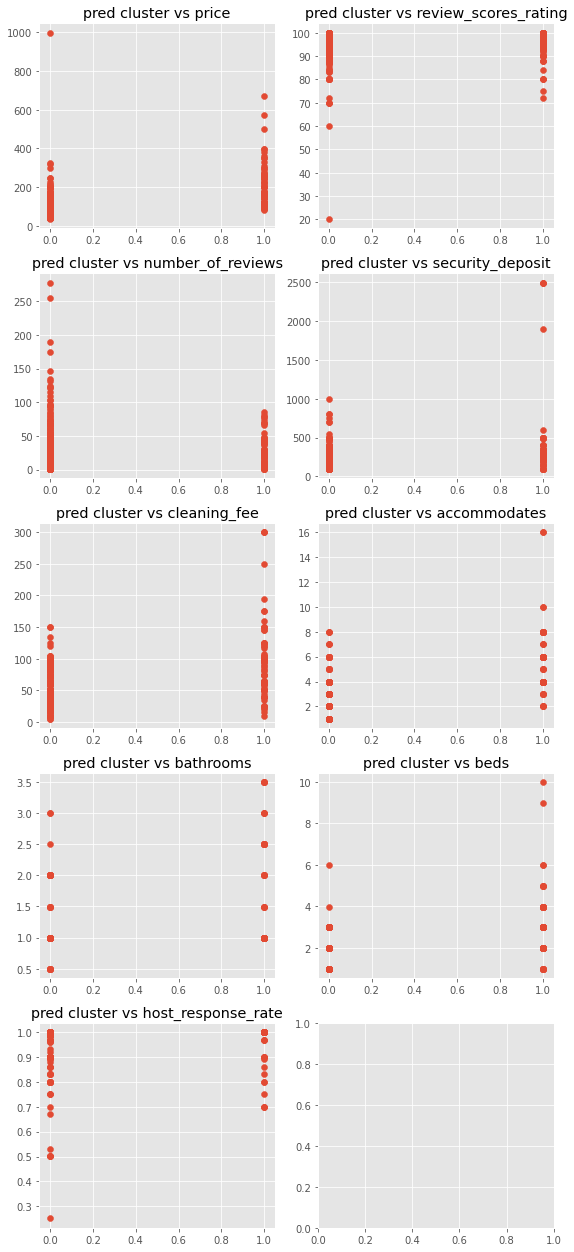

In [331]:
num_row = 5
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    
    ax.scatter(x=predicted_cluster, y=df_inverse_transformed.loc[:, df_inverse_transformed.columns[i]])
    
    ax.set_title(f'pred cluster vs {df_inverse_transformed.columns[i]}')

plt.tight_layout()
plt.show()

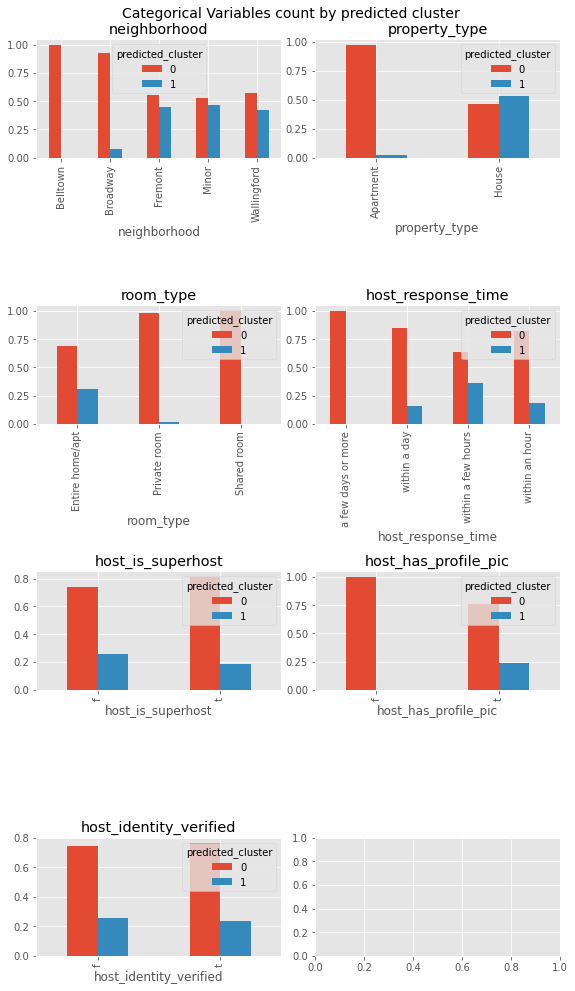

In [332]:
df_categorical['predicted_cluster'] = predicted_cluster

num_row = 4
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))
plt.suptitle('Categorical Variables count by predicted cluster', fontsize=14)

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    ctab=pd.crosstab(df_categorical.iloc[:, i], df_categorical['predicted_cluster'], normalize='index')
    ctab.plot.bar(ax=ax)
  
    ax.set_title(f'{df_categorical.columns[i]}')

plt.tight_layout()
plt.show()

### 5.2. Clustering with k=3 Clusters

Next, let's examine *just* the two *new* clusters that were created when we split one of the clusters going from the clustering with k=2 clusters to the clustering with k=3 clusters.

#### 5.2.1. Finding the cluster labels

First, in the clustering with k=3 clusters, what are the cluster labels belonging to these two clusters that were created by splitting one of the clusters in the clustering with k=2 clusters?

In [333]:
print('cluster 0 count: ', sum(predicted_cluster==0))
print('cluster 1 count: ', sum(predicted_cluster==1))

cluster 0 count:  258
cluster 1 count:  81


In [334]:
Z = linkage(dist_mat, method='complete')
hac = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='complete')
predicted_cluster = hac.fit_predict(dist_mat)

In [335]:
predicted_cluster

array([0, 1, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 2, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 1, 2,
       0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       0, 0, 0, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2,
       0, 0, 1, 0, 1, 0, 1, 0, 2, 2, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 2,
       2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 2,

In [336]:
print('cluster 0 count: ', sum(predicted_cluster==0))
print('cluster 1 count: ', sum(predicted_cluster==1))
print('cluster 2 count: ', sum(predicted_cluster==2))

cluster 0 count:  81
cluster 1 count:  190
cluster 2 count:  68


> We have the cluster labels as 0, 1, 2.

> Cluster 0 has been split further. The two new clusters have labels 1 and 2.

#### 5.2.2. Cluster Characterization

We can think of these two clusters as the second most distinct set of clusters in the dataset (according to the complete linkage function).

What attributes had a strong association with these two newly formed clusters? What attribute values characterize these two clusters in this dataset? You should examine both the numerical and categorical attributes here. For the numerical attributes, make sure that you look at the **unscaled data**.

> Numerical Attributes: The two new clusters have following differences: Cluster with label 2 has low price, low accomodates, less beds and low cleaning fees compared to cluster 1.

> Categorical Attributes Observation: Cluster 1 has mostly apartments, whereas cluster 2 has mostly house.

> Cluster 2 has more private and shared rooms.

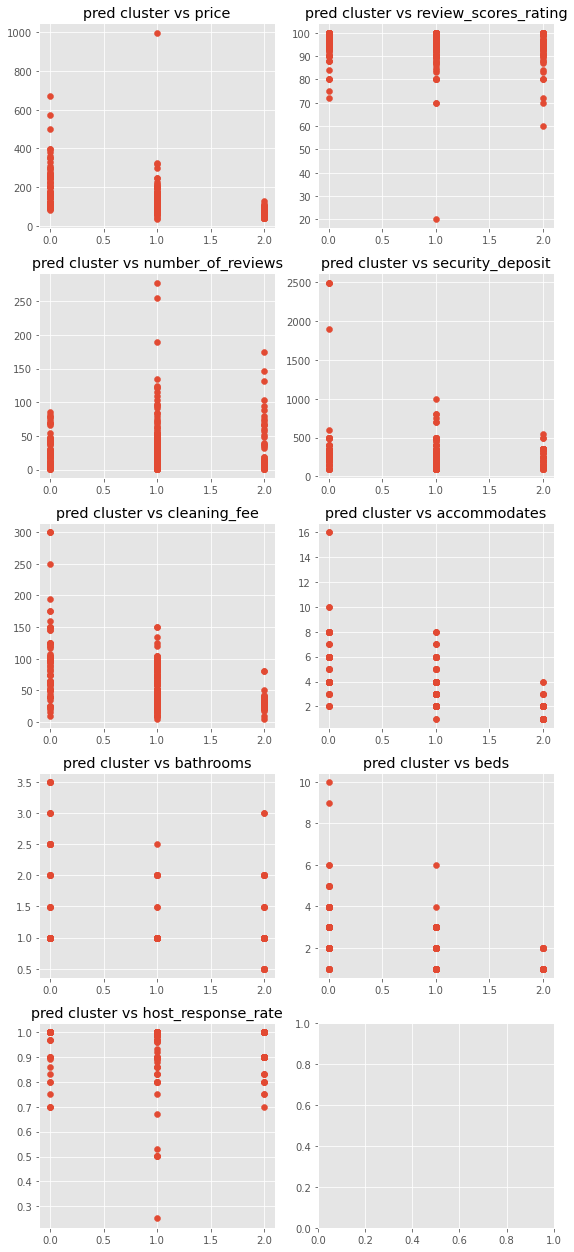

In [337]:
num_row = 5
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    
    ax.scatter(x=predicted_cluster, y=df_inverse_transformed.loc[:, df_inverse_transformed.columns[i]])
    
    ax.set_title(f'pred cluster vs {df_inverse_transformed.columns[i]}')

plt.tight_layout()
plt.show()

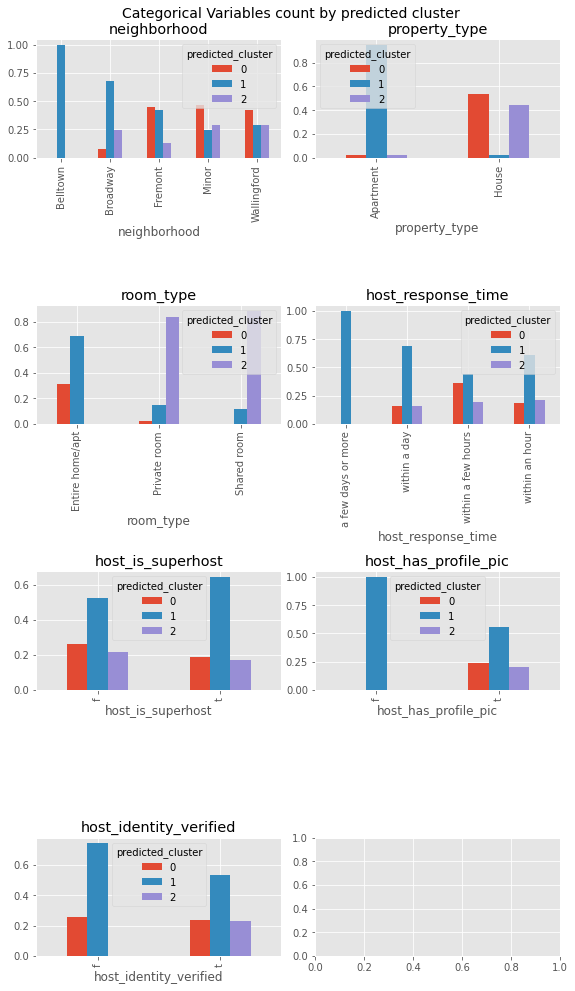

In [338]:
df_categorical['predicted_cluster'] = predicted_cluster

num_row = 4
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))
plt.suptitle('Categorical Variables count by predicted cluster', fontsize=14)

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    ctab=pd.crosstab(df_categorical.iloc[:, i], df_categorical['predicted_cluster'], normalize='index')
    ctab.plot.bar(ax=ax)
  
    ax.set_title(f'{df_categorical.columns[i]}')

plt.tight_layout()
plt.show()

<hr>

## <u>Case Study 2</u>: Seattle Airbnb Listing Analysis - Reduced Dataset - *Just Categorical Variables*

Next, we would like to try clustering our Airbnb listing dataset now using just the categorical variables. How will our results differ when just considering the categorical variables?

## 6. Data Preprocessing and Cleaning

### 6.1. Categorical Dataset

Next, create a dataframe that is just comprised of the categorical variables.

In [340]:
df_categorical.drop(columns=['predicted_cluster'], inplace=True)
df_categorical.head(2)

neighborhood property_type        room_type  host_response_time  \
0  Wallingford         House  Entire home/apt  within a few hours   
1  Wallingford     Apartment  Entire home/apt      within an hour   

  host_is_superhost host_has_profile_pic host_identity_verified  
0                 t                    t                      t  
1                 f                    t                      t

### 6.2. Hamming distance matrix

Finally, create a Hamming distance matrix of your categorical variables.

In [343]:
label_enc = {}
for col in df_categorical.columns:
    label_enc[col] = preprocessing.LabelEncoder()
    df_categorical[col] = label_enc[col].fit_transform(df_categorical[col])

In [344]:
dist_mat = squareform(pdist(df_categorical, metric='hamming'))
dist_mat

array([[0.        , 0.42857143, 0.42857143, ..., 0.57142857, 0.28571429,
        0.42857143],
       [0.42857143, 0.        , 0.        , ..., 0.14285714, 0.42857143,
        0.28571429],
       [0.42857143, 0.        , 0.        , ..., 0.14285714, 0.42857143,
        0.28571429],
       ...,
       [0.57142857, 0.14285714, 0.14285714, ..., 0.        , 0.28571429,
        0.14285714],
       [0.28571429, 0.42857143, 0.42857143, ..., 0.28571429, 0.        ,
        0.14285714],
       [0.42857143, 0.28571429, 0.28571429, ..., 0.14285714, 0.14285714,
        0.        ]])

## 7. Clusterability

### 7.1. t-SNE Plots
Using 6 different perplexity values and at least two random states for each perplexity value, map this **distance matrix** onto a two-dimensional dataset with the t-SNE algorithm. Show your projected coordinates in a scatterplot for each combination of random states and perplexity value.

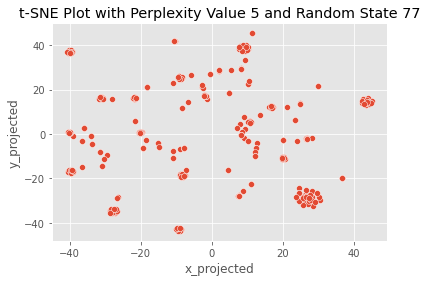

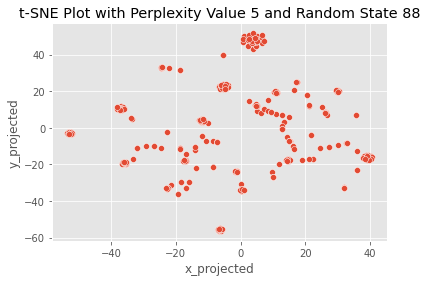

--------------------------------------------


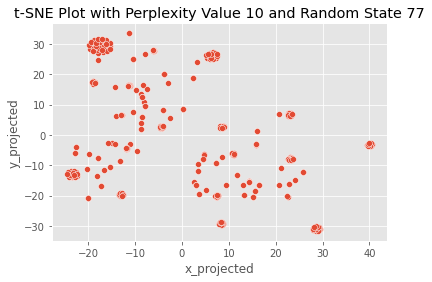

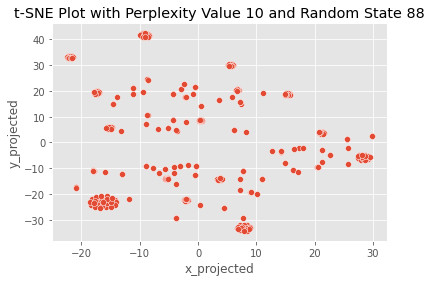

--------------------------------------------


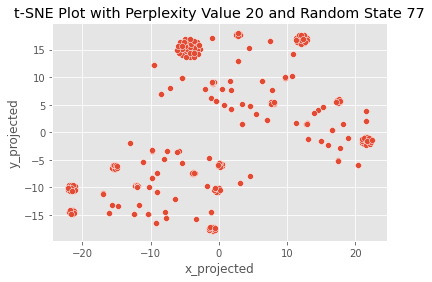

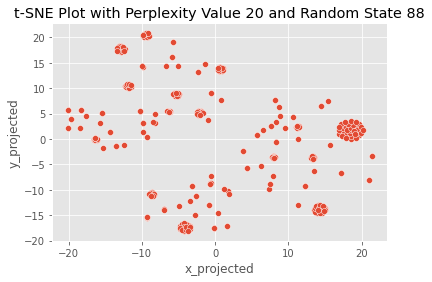

--------------------------------------------


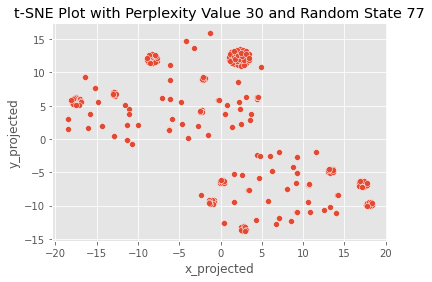

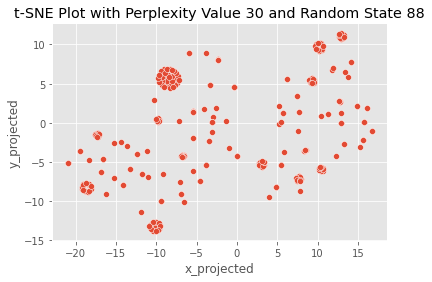

--------------------------------------------


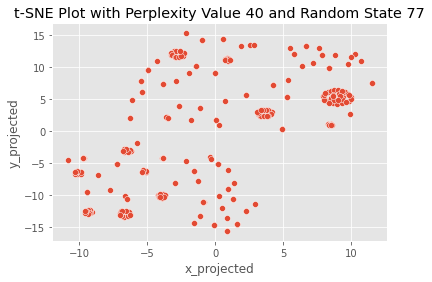

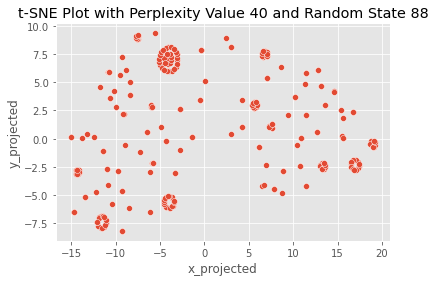

--------------------------------------------


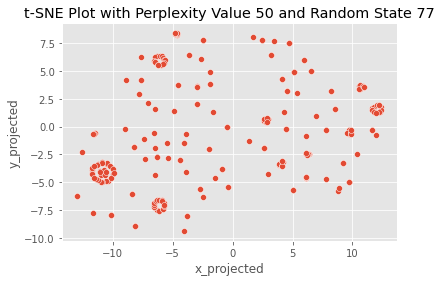

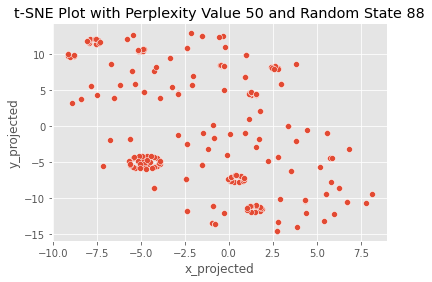

--------------------------------------------


In [346]:
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [77, 88]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

### 7.2 Assessing Clustering Structure

Answer the following questions below.

1. Does the t-SNE algorith suggest that this dataset is clusterable?
2. How many "main clusters" do you think that this dataset has? *[Subjective Answer: As long as your logic is correct, you will not lose points].*

Finally, pick out a random state and perplexity value that reflects the answers to your questions and show the corresponding t-SNE plot below.

> 1. The 2 dimensional t-SNE plot suggests that there are dense clusters with noise. Looking at random state 88, perplexity value of 30, it seems that the dataset is clusterable.

> 2. There seems to be three or four main clusters in the dataset. We can see dense clusters with noise around it, if we remove the noise, we can end up with potentially 3 or 4 clusters.

### 7.3. Association between the Attributes and the Clustering Structure Suggested by the t-SNE Plots

Finally, we would like to assess how each of our 7 categorical attributes is individually associated with the clustering structure suggested by our selected t-SNE from 7.2. In the code below, plot your t-SNE plot 7 times, each time color coding the points by each of the 7 categorical attributes.

In [370]:
np.arange(0, len(df.neighborhood.unique()))

array([0, 1, 2, 3, 4])

In [368]:
df.neighborhood.unique()

array(['Wallingford', 'Minor', 'Belltown', 'Broadway', 'Fremont'],
      dtype=object)

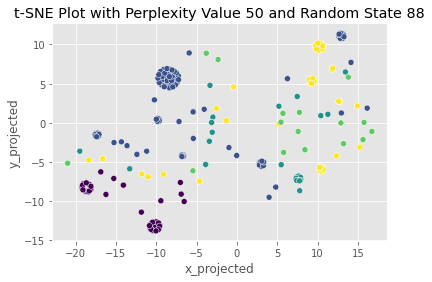

In [383]:
tsne = TSNE(n_components=2, perplexity=30, random_state=88, metric='precomputed')
data_tsne = tsne.fit_transform(dist_mat)
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df, df_tsne], axis=1)

plt.show()

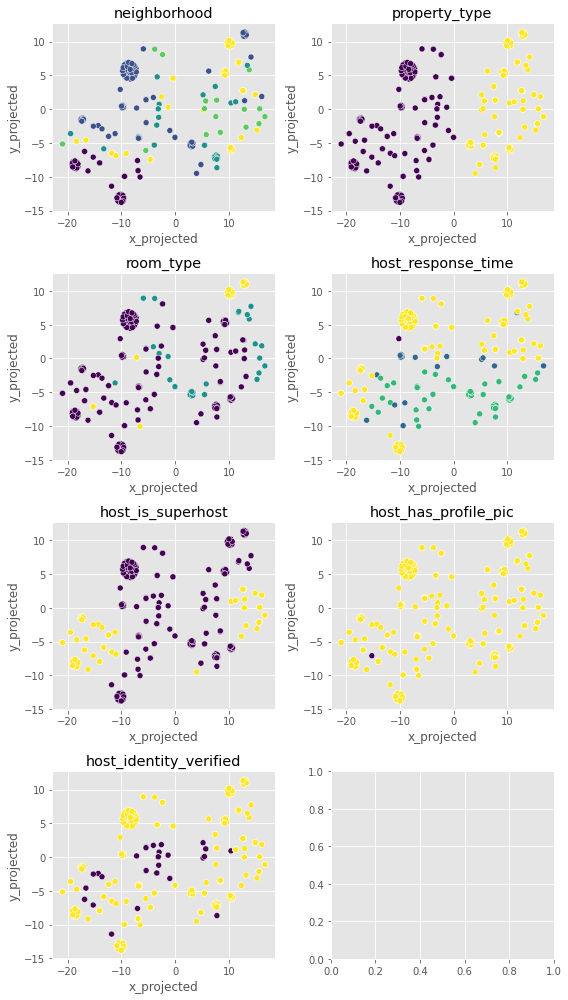

In [390]:
num_row = 4
num_col = 2

# get a segment of the dataset
num = num_row*num_col

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col,3.5*num_row))

for i in range(num_row* num_col-1):
    ax = axes[i//num_col, i%num_col]
    
    sns.scatterplot(x='x_projected',y='y_projected', data=df_combo,
                    c=df_categorical.iloc[:,i], ax=ax)
    
    ax.set_title(f'{df_categorical.columns[i]}')

plt.tight_layout()
plt.show()

### 7.4. Interpretation

Select one of the smaller *highly* dense clouds of points in your t-SNE plot. Do the categorical attribute values in the points in this dense cloud that you selected differ at all?

> We can see in the above plot that the categorical attribute values in the points in the dense clouds do not differ.

## 8. K-Modes - *Parameter Selection*

Next, we would like to cluster this dataset with the k-modes algorithm. We would like to explore what the best values of $k$  would be to use in this clustering algorithm to meet our research goals.


### 8.1. Elbow Plot

Create an elbow plot for the k-modes algorithm. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-modes algorithm, using a random state of 100.

### 8.2. t-SNE Plots

For k=1, k=2,..., k=10, run the k-modes clustering algorithm on your dataset, using a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

### 8.3. Interpretation

How many clusters does your elbow plot suggest are in this dataset? Does the k-modes clustering with this k number of clusters *strongly* agree with the clustering structured suggested by the t-SNE plot?

## 9. Hierarchical Agglomerative Clustering

Next, we would like to cluster our Hamming distance matrix with hierarchical agglomerative clustering using single linkage, complete linkage, and average linkage.



### 9.1. Single Linkage

#### 9.1.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with single linkage for using your Hamming distance matrix. 
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

#### 9.1.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

### 9.2. Complete Linkage

#### 9.2.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with complete linkage using your Hamming distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

#### 9.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

### 9.3. Average Linkage

#### 9.3.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with average linkage using your Hamming distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

#### 9.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

## More information (if you're interested)

In a full analysis, it would also be insightful to do the following.

1. Create a t-SNE plot with just the numerical variables and run a numerical clustering algorithm on the numerical dataset (like k-means).

2. Then select your besting clusterings that you found with the a.) full mixed dataset, b.) the categorical variables dataset, and the c.) numerical variables dataset.

3. To what extent do these clusterings agree? You could use the adjusted rand score, homogeneity score, completeness score, V-score (or other clustering comparison metrics) to compare them.

